# Data Loading

In [1]:
import xarray as xr

from einops import rearrange

ModuleNotFoundError: No module named 'xarray'

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
np.random.seed(42)
torch.manual_seed(42)

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from torch import nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report

import itertools



#taken from the model building section - 
import pandas as pd
pd.set_option('max_colwidth', 800)


import torch.optim as optim


import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import json

import ast


from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from torchinfo import summary

ModuleNotFoundError: No module named 'torchinfo'

In [ ]:
import os

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') ;device

device(type='cpu')

In [ ]:
def convert_string_to_tuple_list(string_list):
    tuple_list = []
    for string in string_list:
        # Remove leading and trailing whitespace and parentheses
        string = string.strip('()')
        # Convert string to tuple using ast.literal_eval
        tuple_value = ast.literal_eval(string)
        tuple_list.append(tuple_value)
    return tuple_list

def remove_non_label(tensor):

    channel_2_values = tensor[:, 1]
    reshape = channel_2_values.view(channel_2_values.shape[0], -1)
    nan_mask = torch.isnan(reshape).all(dim=1)
    tensor_data = tensor[~nan_mask]
    return tensor_data

def replace_keys_with_sequential_integers(dictionary):
    new_dict = {}
    keys = list(dictionary.keys())
    for i in range(len(keys)):
        new_dict[i] = dictionary[keys[i]]
    return new_dict

In [6]:
def get_metrics_binar2(ground_truth,predicted,labels=[1,2],smallest_event_level=None,return_matrix=False):
    
    o = ground_truth.copy()
    p = predicted.copy()

    if type(o)!=np.ndarray:
        o = o.detach().cpu().numpy()
        p =  p.detach().cpu().numpy()
    if smallest_event_level is not None: #added change, label the others as 1, not quite clear why it wasnt the case

        
        o = np.where(o == 0, 0, np.where(o < smallest_event_level, 1, 2))
#         p = np.where(p == 0, 0, np.where(p < smallest_event_level, 1, 2))
        
        if np.all(o == 0):
            return [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,]
    
    
    tn, fp, fn, tp = confusion_matrix(o,p,labels=labels).ravel()
    acc = (tp+tn)/(tp+fp+tn+fn)
    if tp+fp==0:
        prc = np.nan
    else:
        prc = tp/(tp+fp)
    if tp+fn==0:
        rcl = np.nan
    else:
        rcl = tp/(tp+fn)
    if rcl==np.nan or prc==np.nan or rcl==0:
        prcrcl_ratio = np.nan
        prcrcl_avg = np.nan
    else:
        prcrcl_ratio = prc/rcl
        prcrcl_avg = (prc+rcl)/2
    if tp+fp+fn==0:
        csi = np.nan
    else:
        csi = tp/(tp+fp+fn)
    
    if return_matrix:
        return [acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi], confusion_matrix(o,p,labels=labels)

    return [acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi]       

In [7]:
with open('new_lats_dict.json') as json_file:
        new_lats_dict = json.load(json_file)
inv_lats_dict = {value : int(key) for key, value in new_lats_dict.items()}  
with open('new_lons_dict.json') as json_file:
    new_lons_dict = json.load(json_file)
inv_lons_dict = {value : int(key) for key, value in new_lons_dict.items()}  
with open('pixel_to_station_id.pkl', 'rb') as f:
    lat_lon_to_station_id = pickle.load(f)
    
with open("saved_turkey_lat_lon_cords", "rb") as fp:   # Unpickling
    saved_turkey_lat_lon_cords = pickle.load(fp)

with open("saved_turkey_lat_lon_idx", "rb") as fp:   # Unpickling
    saved_turkey_lat_lon_idx = pickle.load(fp)
    
with open("saved_greece_lat_lon_cords", "rb") as fp:   # Unpickling
    saved_greece_lat_lon_cords= pickle.load(fp)

with open("saved_greece_lat_lon_idx", "rb") as fp:   # Unpickling
    saved_greece_lat_lon_idx = pickle.load(fp)
    
saved_turkey_lat_lon_cords = convert_string_to_tuple_list(saved_turkey_lat_lon_cords)
saved_turkey_lat_lon_cords.append((35.0,27.0))
saved_turkey_lat_lon_cords.append((35.0, 45.5))


with open("saved_turkey_and_greece_lat_lon_cords", "rb") as fp:   # Unpickling
    saved_turkey_and_greece_lat_lon_cords= pickle.load(fp)

with open("saved_turkey_and_greece_lat_lon_idx", "rb") as fp:   # Unpickling
    saved_turkey_and_greece_lat_lon_idx = pickle.load(fp)


In [8]:
def check_timestamps(timestamps):
    for i in range(len(timestamps) - 1):
        current_timestamp = timestamps[i]
        next_timestamp = timestamps[i + 1]
        time_difference = current_timestamp  - next_timestamp

        if time_difference != np.timedelta64(3, 'h'):
            return False
    
    return True

In [9]:
def update_dict_keys(dict_to_update, lat_dict, lon_dict):
    updated_dict = {}

    min_lat, max_lat = min(lat_dict), max(lat_dict)
    min_lon, max_lon = min(lon_dict), max(lon_dict)

    for key, value in dict_to_update.items():
        lat_lon = key.strip('[]').split()
        lat = float(lat_lon[0])
        lon = float(lat_lon[1])

        if lat < min_lat or lat > max_lat or lon < min_lon or lon > max_lon:
            continue

        new_lat = lat_dict.get(lat, lat)
        new_lon = lon_dict.get(lon, lon)

        new_key = f'[{new_lat} {new_lon}]'
        updated_dict[new_key] = value

    return updated_dict

from itertools import islice
sliced_dict = dict(islice(inv_lons_dict.items(), 15))
tensor_ids_stations_dict = update_dict_keys(lat_lon_to_station_id,inv_lats_dict,sliced_dict)

In [48]:
# greecee_stations = pd.read_csv('greecee_stations.csv')

# Create dicts for occureance in loader

In [11]:
# counts_tests = {i: 0 for i in range(38)}

# # Iterate through the batches in the test loader
# for _, y_batch in testloader:
#     # Iterate through each batch's tensor
#     for y_sample in y_batch:
#         # Iterate through each station's value in the sample
#         for station_idx, station_value in enumerate(y_sample):
#             if station_value.item() != 0:  # Check if the value is not zero
#                     counts_tests[station_idx] += 1

# counts_train = {i: 0 for i in range(38)}

# # Iterate through the batches in the test loader
# for _, y_batch in trainloader:
#     # Iterate through each batch's tensor
#     for y_sample in y_batch:
#         # Iterate through each station's value in the sample
#         for station_idx, station_value in enumerate(y_sample):
#             if station_value.item() != 0:  # Check if the value is not zero
#                     counts_train[station_idx] += 1
                    
# counts_validation = {i: 0 for i in range(38)}

# # Iterate through the batches in the test loader
# for _, y_batch in validationloader:
#     # Iterate through each batch's tensor
#     for y_sample in y_batch:
#         # Iterate through each station's value in the sample
#         for station_idx, station_value in enumerate(y_sample):
#             if station_value.item() != 0:  # Check if the value is not zero
#                     counts_validation[station_idx] += 1
                    
# with open('counts_tests.json', 'w') as json_file:
#     json.dump(counts_tests, json_file)
# with open('counts_train.json', 'w') as json_file:
#     json.dump(counts_train, json_file)
# with open('counts_validation.json', 'w') as json_file:
#     json.dump(counts_validation, json_file)

# going to 10 levels

In [49]:
coords = pd.read_csv('coords_greecee.csv',index_col=0)
greecee_list = greecee_stations.drop('time',axis=1).columns.tolist()
greecee_list = [int(x) for x in greecee_list ]
coords = coords.query('station_id in @greecee_list').reset_index(drop=True)
coords
l = coords[['lat','lon']].values.tolist()
str_l = [ str(x) for x in l]
coords['lat_lon'] = str_l

In [50]:
biggest_stations = greecee_stations.set_index('time').notnull().sum().sort_values(ascending=False).iloc[:50].index

In [51]:
coords = pd.read_csv('coords_greecee.csv',index_col=0)
biggest_stations = [int(x) for x in biggest_stations ]
coords = coords.query('station_id in @biggest_stations').reset_index(drop=True)

In [52]:
stations_to_use = coords.sort_values('lat').reset_index(drop=True).groupby(['lat','lon']).first()['station_id'].values.tolist()
stations_to_use = [str(x) for x in stations_to_use]

In [54]:
thresholds

tensor([11.6667, 16.6000, 20.6667, 24.8500, 29.3667, 35.0000, 42.6500, 55.0566,
        84.0000], dtype=torch.float64)

In [53]:
# Flatten the DataFrame into a 1D array
num_bins=10
b=greecee_stations.drop('time',axis=1)
torch_tensor = torch.tensor(b.values)
torch_tensor[torch_tensor == 0] = np.nan

non_null_values = torch_tensor[torch.logical_not(torch.isnan(torch_tensor))]
thresholds = torch.tensor([torch.quantile(non_null_values, i/num_bins) for i in range(1, num_bins)])

bins = torch.bucketize(non_null_values, thresholds)


bins = torch.bucketize(non_null_values, thresholds)
bins += 1
torch_tensor[torch.logical_not(torch.isnan(torch_tensor))] = bins.to(torch.float64)

torch_tensor[torch.isnan(torch_tensor)] = 0

df_categories = pd.DataFrame(torch_tensor.numpy())

df_categories.columns=greecee_stations.drop('time',axis=1).columns
df_categories = df_categories.assign(time=greecee_stations['time'])



d = df_categories.set_index('time')
take_out_bad_stations = d.columns[d.var(axis=0)!=0]
df_categories = df_categories[take_out_bad_stations.tolist()].assign(time=greecee_stations['time'])
num_stations = len(df_categories.set_index('time').columns.tolist())

df_categories.drop('time',axis=1).stack().value_counts()

# Creating a dict for stations/ids

result_dict = {index: num for index, num in enumerate(df_categories.drop('time',axis=1).columns)}

# print(result_dict)

In [228]:
# with open('stations_dict.pkl', 'wb') as f:
#     pickle.dump(result_dict, f)

In [4]:
df_categories = pd.read_csv('greecee_quantiles_sublist_of_stations.csv',index_col=0)

In [5]:
final_tensor = torch.load('tensor_new_correction_model2.pt')

In [12]:
# final_tensor = torch.load('final_test_tensor.pt')
# # final_tensor = torch.load('final_test_tensor_corr.pt')

# #index 0 in channels is pm10, index 1 is pm10 with correction

In [17]:
# with open('result_dict.json', 'r') as json_file:
#     result_dict = json.load(json_file)
with open('stations_dict_subset.json', 'r') as f:
    result_dict = json.load(f)
# with open('stations_dict.json', 'r') as f:
#     result_dict = json.load(f)

result_dict = {int(key):int(value) for key, value in result_dict.items()}

# super resoultion

In [ ]:
import sys
sys.path.insert(0, '../helpers')
from plotting import *

In [7]:
df = df_categories.set_index('time')

In [13]:
coords = pd.read_csv('coords_greecee.csv',index_col=0);coords
coords['loc'] = coords[['lat','lon']].values.tolist()

In [70]:
time_dict = {v:k for k,v in df_categories['time'].to_dict().items()}

In [73]:
result_dict = {}

for index, row in df.iterrows():
    for column, value in row.items():
        if value == 2:
            if index in result_dict:
                c = int(column)
                result_dict[index].append(coords.query('station_id == @c')['loc'].values[0])
            else:
                c = int(column)
                result_dict[index] = [coords.query('station_id == @c')['loc'].values[0]]


In [78]:
time_dict['2013-01-06 09:00:00+00:00']

29267

{'2013-01-05 00:00:00+00:00': [[42.13100000000001, 20.4341]],
 '2013-01-05 18:00:00+00:00': [[42.13100000000001, 20.4341]],
 '2013-01-05 21:00:00+00:00': [[42.13100000000001, 20.4341]],
 '2013-01-06 00:00:00+00:00': [[42.13100000000001, 20.4341],
  [42.1355599994657, 21.71474]],
 '2013-01-06 03:00:00+00:00': [[41.99758999946595, 20.96518],
  [42.0036099994659, 21.46362]],
 '2013-01-06 06:00:00+00:00': [[41.7058299994665, 21.76529],
  [41.99758999946595, 20.96518],
  [42.0036099994659, 21.46362],
  [42.0059999994659, 21.387],
  [42.1355599994657, 21.71474]],
 '2013-01-06 09:00:00+00:00': [[42.0059999994659, 21.387],
  [42.1355599994657, 21.71474]],
 '2013-01-07 12:00:00+00:00': [[42.1355599994657, 21.71474]],
 '2013-01-07 15:00:00+00:00': [[41.99758999946595, 20.96518],
  [42.0059999994659, 21.387]],
 '2013-01-08 00:00:00+00:00': [[42.0059999994659, 21.387]],
 '2013-01-08 03:00:00+00:00': [[42.1355599994657, 21.71474]],
 '2013-01-08 06:00:00+00:00': [[42.0059999994659, 21.387],
  [42.13

In [38]:
colab_dir = "/home/labs/rudich/Collaboration/dust_prediction/data"
meteo_dir = colab_dir+"/interpolated_mean_normalized/"
meteo_de_dir = colab_dir+"/meteorology_renormalization_tensors"
dust_dir = colab_dir+"/dust_61368_108_2_339/"

meteo_meta = torch.load(meteo_dir+"/meteorology_tensor_62_81_189_metadata.pkl")
dust_meta = torch.load(dust_dir+"/dust_61368_108_2_339_metadata.pkl")

lons_dict = meteo_meta['dims']['lons']
lats_dict = meteo_meta['dims']['lats']

lat_start, lat_end = 10, 75
lon_start, lon_end = 50, 117
lons_start =lons_dict[50]
lons_end =lons_dict[117]
lats_start =lats_dict[10]
lats_end =lats_dict[75]
step = 0.5

lons = [lons_start + i * step for i in range(int((lons_end - lons_start) / step) )]
lats = [lats_start + i * step for i in range(int((lats_end - lats_start) / step) )]

<Figure size 640x480 with 0 Axes>

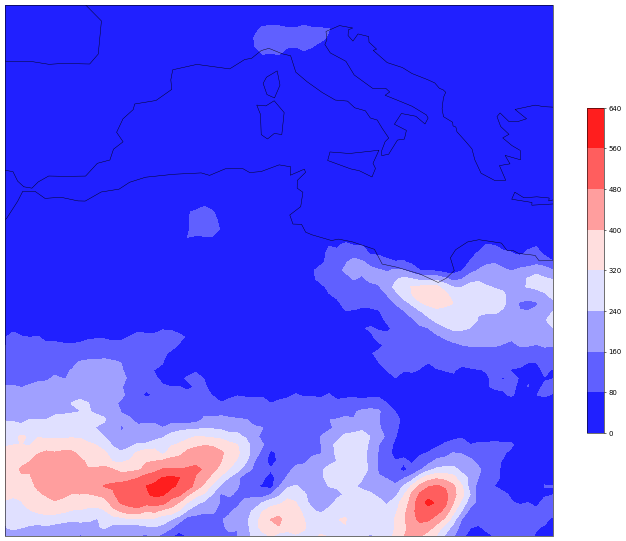

In [79]:
print_parameter(final_tensor[29267], 1,lons=lons,lats=lats,figsize=(14,18))

<Figure size 640x480 with 0 Axes>

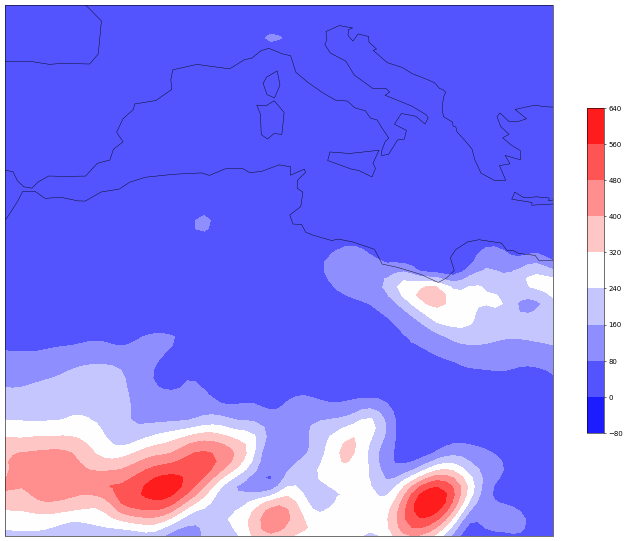

In [80]:
print_parameter(final_tensor[29267], 0,lons=lons,lats=lats,figsize=(14,18))

# Classes 

In [18]:
class CustomDataset(Dataset):
    def __init__(self, tensor_input, dataframe_target,label_tensor, time_to_predict=24, lookback_num=1):
        self.tensor_input = tensor_input
        self.dataframe_target = dataframe_target
        self.label_tensor = label_tensor
        if time_to_predict == 0 or time_to_predict % 3 == 0:
            self.time_to_predict = time_to_predict
        else:
            raise ValueError('Can only predict hours in jumps of 3')
            
        self.lookback_num = lookback_num


            
    def __len__(self):
        return self.tensor_input.shape[0]  # Number of samples

    def __getitem__(self, index):
        
        
        if self.lookback_num > 0:
        # Check the condition for the current index
            if index >= self.lookback_num: 

                a = self.dataframe_target.loc[index-self.lookback_num:index-2,'time'].values
                t = np.append(a,self.dataframe_target.loc[index-1,'time'].to_numpy())

                if check_timestamps(t[::-1]):
                    c = np.arange(index-self.lookback_num,index+1)
                    input_data = self.tensor_input[c,:,:,:]
                    input_data = input_data.view(len(c),input_data.shape[2], input_data.shape[3])

            if index < self.lookback_num or not check_timestamps(t[::-1]):
                input_data = torch.full((1,1),-999) #error indicator
        
        elif self.lookback_num == 0:
            input_data = self.tensor_input[index]
            
        else:
            raise ValueError('lookback_num cant be a negative number')


        
        #handling Target data
        
        X_timestamp = self.dataframe_target.loc[index,'time']
        target_timestamp = X_timestamp + pd.DateOffset(hours=self.time_to_predict)
        matching_row = self.dataframe_target[self.dataframe_target['time'] == target_timestamp]

        if len(matching_row) > 0:

            matching_row = matching_row.index.values[0]
            target_data = self.label_tensor[matching_row]
#             print(f' if_point {target_data.shape}')
            
        else:
#             print(f' X timestamp {X_timestamp}, no corresponding futuretimestamp')
            target_data = torch.full((1,self.label_tensor.shape[1]), 0)[0]
#             print(f'else_point {target_data.shape}')
        
        time = self.dataframe_target.loc[index,'time']
        return input_data, target_data, time


class SequentialDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        X, y = self.data[index]
        return X, y

    def __len__(self):
        return len(self.data)

class SequentialDataset2(Dataset):
    def __init__(self, data):
        self.x = data[0]
        self.y = data[1]
    
    def __getitem__(self, index):
        X, y = self.x[index], self.y[index]
        return X, y

    def __len__(self):
        return len(self.x)
    
    
    
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') ;device

device(type='cpu')

In [19]:
class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dilation=1):
        super(ResidualBlock3D, self).__init__()

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1,dilation=dilation,bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1,dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ClassificationResNet3D(nn.Module):
    def __init__(self, input_shape, num_classes, num_stations):
        super(ClassificationResNet3D, self).__init__()

        channel, lat_index, lon_index = input_shape

        self.conv1 = nn.Conv3d(channel, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))

        self.stage1 = self.make_stage(64, 64, num_blocks=1, stride=1)
        self.stage2 = self.make_stage(64, 128, num_blocks=2, stride=(1, 2, 2))
        self.stage3 = self.make_stage(128, 256, num_blocks=2, stride=(1, 2, 2))
        self.stage4 = self.make_stage(256, 512, num_blocks=2, stride=(1, 2, 2))

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc1 = nn.Linear(512, num_stations * num_classes)

        self.num_stations = num_stations
        self.num_classes = num_classes

    def make_stage(self, in_channels, out_channels, num_blocks, stride, dilation=1):
        layers = []
        layers.append(ResidualBlock3D(in_channels, out_channels, stride=stride, dilation=dilation))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock3D(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = out.view(-1, self.num_classes, self.num_stations)
        out = out.permute(0, 2, 1)
        return out

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels,stride,  dilation=1, reduce=False):
        super(ResidualBlock, self).__init__()
        
        if reduce:
        
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, dilation=dilation, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU(inplace=True)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1,dilation=dilation, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.shortcut = nn.MaxPool2d((2,2))
        else:
            self.conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=dilation, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU(inplace=True)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=dilation, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)            
            self.shortcut = None

        
            

    def forward(self, x):
        
        if self.shortcut == None:
            identity = x.clone()
        else: 
            identity = self.shortcut(x)
            
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity

        out = self.relu(out)
        return out

class ClassificationResNet(nn.Module):
    #NN architecture - conv_bn_activation_pooling > res block that stays in the same dim > dim reduction with conv
    def __init__(self, input_shape, num_classes, num_stations, channel_zero=8):
        super(ClassificationResNet, self).__init__()

        channel, lat_index, lon_index = input_shape

        self.conv1 = nn.Conv2d(channel, channel_zero, kernel_size=(8,10), stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(channel_zero)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stage1 = self.make_stage(channel_zero, channel_zero, num_blocks=1, stride=2,dilation=1,reduce=False)
        self.conv2 = nn.Conv2d(channel_zero, channel_zero*2, kernel_size=3, stride=2, padding=1, dilation=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channel_zero*2)
        
        self.stage2 = self.make_stage(channel_zero*2, channel_zero*2, num_blocks=2, stride=2,dilation=1,reduce=False)
        self.conv3 = nn.Conv2d(channel_zero*2, channel_zero*4, kernel_size=3, stride=2, padding=1, dilation=1, bias=False)
        self.bn3 = nn.BatchNorm2d(channel_zero*4)
        
        
        self.stage3 = self.make_stage(channel_zero*4, channel_zero*4, num_blocks=2, stride=2,dilation=1,reduce=False)
        self.conv4 = nn.Conv2d(channel_zero*4, channel_zero*8, kernel_size=3, stride=2, padding=1, dilation=1,  bias=False)
        self.bn4 = nn.BatchNorm2d(channel_zero*8) 
        
        self.stage4 = self.make_stage(channel_zero*8, channel_zero*8, num_blocks=2, stride=2,dilation=1, reduce=False)
        self.conv5 = nn.Conv2d(channel_zero*8, channel_zero*16, kernel_size=3, stride=2, padding=2, dilation=2,  bias=False)
        self.bn5 = nn.BatchNorm2d(channel_zero*16) 
        

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(channel_zero*16, channel_zero*8)
        self.fc2 = nn.Linear(channel_zero*8,num_stations * num_classes)
        self.dropout = nn.Dropout(0.5)

        self.num_stations = num_stations
        self.num_classes = num_classes

    def make_stage(self, in_channels, out_channels, num_blocks, stride, dilation,reduce=False):

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels,stride, dilation, reduce))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels,stride,dilation, reduce))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.stage1(out)
        out = self.conv2(out)
        out =self.bn2(out)
        out = self.relu(out)
        
        out = self.stage2(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        
        out = self.stage3(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu(out)

        out = self.stage4(out)
        out = self.conv5(out)
        out = self.bn5(out)
        out = self.relu(out)
        
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
#         out = self.dropout(out)
        out = self.relu(out)
        out = self.fc2(out)
#         out = self.dropout(out)
        out = out.view(-1, self.num_classes, self.num_stations)
        out = out.permute(0, 2, 1)
        
        return out

net = ClassificationResNet((1,65,67),38,11).to(device)
# summary(net, input_size=(128,1,65,67))

In [21]:
class ResidualBlock_old(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock_old, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ClassificationResNet_old(nn.Module):
    def __init__(self, input_shape, num_classes, num_stations):
        super(ClassificationResNet_old, self).__init__()

        channel, lat_index, lon_index = input_shape

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stage1 = self.make_stage(64, 64, num_blocks=1, stride=1)
        self.stage2 = self.make_stage(64, 128, num_blocks=2, stride=2)
        self.stage3 = self.make_stage(128, 256, num_blocks=2, stride=2)
        self.stage4 = self.make_stage(256, 512, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 480)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(480, 460)
        self.fc3 = nn.Linear(460, num_stations * num_classes)
        self.num_stations = num_stations
        self.num_classes = num_classes

    def make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock_old(in_channels, out_channels, stride=stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock_old(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = out.view(-1, self.num_classes, self.num_stations)
        out = out.permute(0, 2, 1)
        return out
    


net = ClassificationResNet_old((1,65,67),38,11).to(device)
# summary(net, input_size=(128,1,65,67))

# Functions

In [22]:
def find_missing_stations(train_loader, test_loader):
    train_stations = set()
    test_stations = set()

    # Extract station indices from the train loader
    for _, labels in train_loader:
        for index in range(138):
            if torch.any(labels[:, index] != 0):
                train_stations.add(index)

    # Extract station indices from the test loader
    for _, labels in test_loader:
        for index in range(138):
            if torch.any(labels[:, index] != 0):
                test_stations.add(index)

    missing_stations = train_stations - test_stations

    return missing_stations

# Call the function with your trainloader and testloader
# missing_stations = find_missing_stations(trainloader, testloader)

# print("Missing stations in test loader:", missing_stations)

In [23]:
def split_dataset_by_size(dataset, train_percentage, validation_percentage, test_percentage):
    total_size = len(dataset)
    
    train_size = int(total_size * train_percentage)
    validation_size = int(total_size * validation_percentage)
    test_size = total_size - train_size - validation_size

    train_indices = list(range(train_size))
    validation_indices = list(range(train_size, train_size + validation_size))
    test_indices = list(range(train_size + validation_size, total_size))

    train_set = [dataset[i] for i in train_indices]
    validation_set = [dataset[i] for i in validation_indices]
    test_set = [dataset[i] for i in test_indices]

    return train_set, validation_set, test_set, train_indices, validation_indices, test_indices


In [24]:
def get_metrics_binar(ground_truth,predicted,labels=[1,2],smallest_event_level=None,return_matrix=False):
    
    o = ground_truth.copy()
    p = predicted.copy()

    if type(o)!=np.ndarray:
        o = o.detach().cpu().numpy()
        p =  p.detach().cpu().numpy()
    if smallest_event_level is not None: #added change, label the others as 1, not quite clear why it wasnt the case

        
        o = np.where(o == 0, 0, np.where(o < smallest_event_level, 1, 2))
        p = np.where(p == 0, 0, np.where(p < smallest_event_level, 1, 2))
        
        if np.all(o == 0):
            return [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,]
    
    # print(o.shape, p.shape)
    tn, fp, fn, tp = confusion_matrix(o,p,labels=labels).ravel()
    acc = (tp+tn)/(tp+fp+tn+fn)
    if tp+fp==0:
        prc = np.nan
    else:
        prc = tp/(tp+fp)
    if tp+fn==0:
        rcl = np.nan
    else:
        rcl = tp/(tp+fn)
    if rcl==np.nan or prc==np.nan or rcl==0:
        prcrcl_ratio = np.nan
        prcrcl_avg = np.nan
    else:
        prcrcl_ratio = prc/rcl
        prcrcl_avg = (prc+rcl)/2
    if tp+fp+fn==0:
        csi = np.nan
    else:
        csi = tp/(tp+fp+fn)
    
    if return_matrix:
        return [acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi], confusion_matrix(o,p,labels=labels)

    return [acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi]       

In [25]:
def find_stations_with_all_zeros(loader):
    
    station_zero_counts = [0] * 138
    
    for i, data in enumerate(loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        for index in range(138):
            station_zero_counts[index] += torch.sum(labels[:, index] == 0).item()
    
    for index, zero_count in enumerate(station_zero_counts):
        if zero_count == len(loader.dataset):
            print("Station index {} has all zero values across all batches".format(index))


In [26]:
def filter_zero_labels(dataset):
    filtered_data = []
    filtered_targets = []

    for data, targets in dataset:
        if not torch.all(targets == 0):
            filtered_data.append(data)
            filtered_targets.append(targets)

    return SequentialDataset2((filtered_data, filtered_targets))

In [27]:
def create_dataset(final_tensor,df_categories, time_to_predict, lookback_num,
                   without_correction=False, batch_size=32,time_split=False,verbose=False):
    
    tensor = (final_tensor[:,:1,:,:] if without_correction else final_tensor[:,1:,:,:])
    df = df_categories.drop('time',axis=1)

    rows_to_keep = df.loc[(df != 0).any(axis=1)].index

    filtered_input_tensor = tensor[rows_to_keep]

    filtered_target_dataframe = (
                                 df_categories.loc[rows_to_keep]
                                 .pipe(lambda d:d.assign(time = pd.to_datetime(d.time)))
                                 .reset_index(drop=True)
                                )

    filtered_target_dataframe = filtered_target_dataframe.astype({col: 'int' for col in df.columns if col != 'time'})


    label_tensor = torch.tensor(filtered_target_dataframe.drop('time',axis=1).values, dtype=torch.float32)

    original_dataset = CustomDataset(filtered_input_tensor,filtered_target_dataframe,label_tensor,time_to_predict=time_to_predict, lookback_num=lookback_num)


    filtered_data_X_y = []
    filtered_data_time = []

    # Filter and split the data
    for X, y, time in original_dataset:
        if (not torch.all(X.eq(-999))) & (not torch.all(y.eq(0))):
            filtered_data_X_y.append((X, y))
            filtered_data_time.append(time)
    new_dataset =  SequentialDataset(filtered_data_X_y)

    
    if time_split:
        if verbose:
            print('time_split')
        train_dataset, validation_dataset, test_dataset, train_indices, validation_indices, test_indices = split_dataset_by_size(filtered_data_X_y, train_percentage=0.7, validation_percentage=0.1, test_percentage=0.2)
        train_dataset, validation_dataset, test_dataset = SequentialDataset(train_dataset), SequentialDataset(validation_dataset), SequentialDataset(test_dataset)

        train_dataset = filter_zero_labels(train_dataset)
        val_dataset = filter_zero_labels(validation_dataset)
        test_dataset = filter_zero_labels(test_dataset)
    else:
        if verbose:
            print('random_split')
        train_dataset, test_dataset, train_indices, test_indices = train_test_split(new_dataset,filtered_data_time, test_size=0.2, random_state=42)
        train_dataset, validation_dataset , train_indices, validation_indices = train_test_split(train_dataset,train_indices, test_size=0.1, random_state=42)

  # Set your desired batch size
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    input_shape = (lookback_num+1, 65, 67)
    
    return trainloader, validationloader, testloader, input_shape ,train_indices, validation_indices, test_indices, filtered_data_time

In [28]:
def train(net, trainloader, validationloader, input_shape, num_stations=138,num_epochs=75,learning_rate=0.1, smallest_event_level=9,verbose=True):
    
    
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
    class_weights = torch.tensor([0,1,1,1,1,1,1,1,1,2,2.]).to(device)
    criterion = nn.CrossEntropyLoss(reduction = 'none',weight=class_weights)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    w = torch.ones(num_stations).to(device)
    train_running_loss = []
    validation_running_loss = []
    train_f1_scores = []
    valid_f1_scores = []

    labels_to_use = [1,2,3,4,5,6,7,8,9,10]

    
    for epoch in range(num_epochs):
        net.train() 
        running_loss = 0.0
        running_loss_val = 0.0
        y_true_train = []
        y_pred_train = []

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

    #         ordinal_labels = convert_to_ordinal_labels(labels, num_classes=12).to(device)

            outputs = net(inputs)
            labels = labels.type(torch.LongTensor).to(device)
            loss = ((criterion(outputs, labels) * (labels>0) * w).mean(0)).mean()
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

            predicted = torch.argmax(outputs, dim=1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())


        train_loss = running_loss / len(trainloader)
        train_running_loss.append(train_loss)


        # Reshape the tensors to merge batch and class dimensions
        predictions_train = np.concatenate(y_pred_train).reshape(-1, num_stations).flatten()
        ground_truth_train = np.concatenate(y_true_train).reshape(-1, num_stations).flatten()

        acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi = get_metrics_binar(ground_truth_train,predictions_train,labels=[1,2],smallest_event_level=smallest_event_level)

        train_f1_scores.append(csi)

        # Validation loop
        net.eval()  # Set the model to evaluation mode
        y_true_valid = []
        y_pred_valid = []
        
        with torch.no_grad():
            for i, data in enumerate(validationloader, 0):
                inputs, labels =data[0].to(device), data[1].to(device)
                outputs = net(inputs)
              
                labels = labels.type(torch.LongTensor).to(device)
                
                loss_val = ((criterion(outputs, labels) * (labels>0) * w).mean(0)).mean()
                outputs = torch.argmax(outputs, dim=1)             
                running_loss_val += loss_val.item()
                y_true_valid.extend(labels.cpu().numpy())
                y_pred_valid.extend(outputs.cpu().numpy())

        # Concatenate predictions and labels along batch dimension
        predictions_valid = np.concatenate(y_pred_valid).reshape(-1, num_stations).flatten()
        ground_truth_valid = np.concatenate(y_true_valid).reshape(-1, num_stations).flatten()

        acc_test, prc_test, rcl_test, prcrcl_ratio_test, prcrcl_avg_test, csi_test = get_metrics_binar(ground_truth_valid,predictions_valid,labels=[1,2],smallest_event_level=smallest_event_level)

        valid_loss = running_loss_val / len(validationloader)
        validation_running_loss.append(valid_loss)
        # Calculate the average validation loss for this epoch
        valid_f1_scores.append(csi_test)
        scheduler.step(valid_loss)
        
        
        f_string_template = f'''Epoch [{epoch+1}/{num_epochs}] - 
              Train Loss: {train_loss:.4f},   Valid Loss: {valid_loss:.4f} \n'''
    
        train_string = f' Train acc {acc:.3f}, Train percision {prc:.3f}, train recall {rcl:.3f}, train csi {csi:.3f}, train avg {prcrcl_avg:.3f}'
        test_string = f' Validation acc {acc_test:.3f}, Validation percision {prc_test:.3f}, Validation recall {rcl_test:.3f}, validation csi {csi_test:.3f}, vald avg {prcrcl_avg_test:.3f}'
        if verbose:
            print(f_string_template + '\n' + train_string  + '\n' + test_string)


    return net, train_running_loss, validation_running_loss

In [29]:
def test_stations(net, testloader, smallest_event_level=9):
    
    net.eval()
    all_predictions = []
    all_labels = []
    all_input = []
    station_pred_label_dict = {}  # Store evaluation metrics for each station

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            predicted_labels = torch.argmax(outputs, dim=1)
            all_predictions.append(predicted_labels.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        

            # calculate confusion matrix for each batch
            for station_idx in range(num_stations):
                #creating a mask to take relevant predictions and labels
                station_predictions = predicted_labels[:,station_idx]
                station_labels = labels[:, station_idx]

                # calculate station-specific metrics
                if station_idx not in station_pred_label_dict:
                    station_pred_label_dict[station_idx] = {'predictions': [], 'labels': []}
                station_pred_label_dict[station_idx]['predictions'].extend(station_predictions.cpu().numpy())
                station_pred_label_dict[station_idx]['labels'].extend(station_labels.cpu().numpy())
        predictions_test = np.concatenate(all_predictions).reshape(-1, num_stations).flatten()
        ground_truth_test = np.concatenate(all_labels).reshape(-1, num_stations).flatten()
        
        total_metrics, cm = get_metrics_binar(ground_truth_test,predictions_test,labels=[1,2],smallest_event_level=smallest_event_level, return_matrix=True)

    stations_metrics = {}
    #  evaluation metrics for each station
    for station_idx, metrics in station_pred_label_dict.items():
        station_predictions = np.array(metrics['predictions'])
        station_labels = np.array(metrics['labels'])
        acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi = get_metrics_binar(station_labels,
                                                                         station_predictions,labels=[1,2],
                                                                         smallest_event_level=smallest_event_level)
        stations_metrics[station_idx] = {'acc':acc, 'prc':prc, 'rcl':rcl,
                                         'prcrcl_ratio':prcrcl_ratio, 'prcrcl_avg':prcrcl_avg,
                                         'csi':csi}
    return stations_metrics, total_metrics, cm

In [30]:
def get_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'fall'
    else:
        return 'winter'

def testing_seasons(net, testloader, test_indices,smallest_event_level=10):
    net.eval()
    all_predictions = []
    all_labels = []
    all_input = []
    station_pred_label_dict = {}  # Store evaluation metrics for each station

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs) #batch, classes, stations
            predicted_labels = torch.argmax(outputs, dim=1)
            all_predictions.append(predicted_labels.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    predictions_test_time_station = np.concatenate(all_predictions).reshape(-1, num_stations)
    ground_truth_test_time_station = np.concatenate(all_labels).reshape(-1, num_stations)

    results_df = pd.DataFrame(index=test_indices, columns=['accuracy','precision', 'recall', 'prcrcl_ratio','prcrcl_avg', 'csi'])

    # Loop over timestamps and compute metrics
    for idx, timestamp in enumerate(test_indices):

        metrics = get_metrics_binar(ground_truth_test_time_station[idx],predictions_test_time_station[idx],labels=[1,2],smallest_event_level=smallest_event_level)
        results_df.loc[timestamp] = metrics
    results_df['index_in_timestamp_list'] = range(0, len(test_indices))
    results_df = results_df.sort_index()



    results_df.index = pd.to_datetime(results_df.index)
    results_df['year'] = results_df.index.year
    results_df['month'] = results_df.index.month
    results_df['season'] = results_df['month'].apply(get_season)
    
    return results_df, predictions_test_time_station.flatten(), ground_truth_test_time_station.flatten()


In [31]:
def get_values_at_indices(value_list, index_list):
    
    '''
    purpose : given a list of just normal indices list of a given dataset split(train/val/test)
              and a full timestamps list, create a new list that if the timestamps at those given indexs
    
    '''
    result = [value_list[index] for index in index_list]
    return result

In [32]:
def fix_indices(train_ind, val_ind, test_ind, times_list):
    
    '''
    apply get_values_functions on all datasets splits
    
    '''
    fixed_train = get_values_at_indices(times_list, train_ind )
    fixed_val = get_values_at_indices(times_list, val_ind)
    fixed_test = get_values_at_indices(times_list, test_ind,)
    
    return fixed_train, fixed_val, fixed_test

In [33]:
def get_stations_list_under_timespan(time_list,greecee_stations):
    
    '''
    
    purpose: gets a time_list(usually the train timelist span) and a df of stations
             return a new list of all stations that have atleast one occurance of non nan events during
             the given time_list_period
    
    '''
    
    time_list = sorted(time_list)
    d = greecee_stations.assign(time=pd.to_datetime(greecee_stations.time))
    d = d.query('time >=  @time_list[0] & time <= @time_list[-1]').drop('time',axis=1)
    df_cleaned = d.dropna(axis=1, how='all')
    stations_list = df_cleaned.columns.tolist()
    print(f'new stations_amount : {len(stations_list)}')
    
    return stations_list

In [34]:
def quick_results_testing(metrics=None,useForcast=False,use_saved_metrics=False):
    
    
    def plot_data_with_regression(df_base, df_corrected, df_cams=None, show_regression=True):
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
        axes = axes.flatten()

        for i, column in enumerate(df_base.columns):
            ax = axes[i]

            ax.scatter(df_base.index, df_base[column], label='base', color='red', alpha=0.5)
            ax.scatter(df_corrected.index, df_corrected[column], label='corrected', color='blue', alpha=0.5)
            if isinstance(df_cams, pd.DataFrame):
                ax.scatter(df_cams.index, df_cams[column], label='Cams_forcast', color='green', alpha=0.5)

            if show_regression:
                base_coeffs = np.polyfit(df_base.index, df_base[column], 1)  # Linear regression coefficients for base
                corrected_coeffs = np.polyfit(df_corrected.index, df_corrected[column], 1)  # Linear regression coefficients for corrected
                if isinstance(df_cams, pd.DataFrame):
                    forcast_coeffs = np.polyfit(df_cams.index, df_cams[column], 1) 
                    forcast_line = np.polyval(forcast_coeffs, df_cams.index)


                base_line = np.polyval(base_coeffs, df_base.index)
                corrected_line = np.polyval(corrected_coeffs, df_corrected.index)
                

                ax.plot(df_base.index, base_line, color='red', label='base regression')
                ax.plot(df_corrected.index, corrected_line, color='blue', label='corrected regression')
                if isinstance(df_cams, pd.DataFrame):
                    ax.plot(df_cams.index, forcast_line, color='green', label='cams_forcast')


            ax.set_title(f' {column}')
            ax.set_xlabel('leap_time')
            ax.set_ylabel('value')
            ax.set_xticks(df_base.index)
            ax.set_xticklabels(df_base.index, rotation=45)


            handles, labels = ax.get_legend_handles_labels()


        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

        plt.tight_layout()
        plt.show()
    
    
    if useForcast:
        with open('leaps_metrics_total_cams_forcast_bad.pkl', 'rb') as f:
            pickle_cams = pickle.load(f)
        df_cams = pd.DataFrame([
        (int(key.split('_')[0]), key.split('_')[1], *values)
        for key, values in pickle_cams.items()
            ], columns=['index_label', 'data_type', 'acc', 'prc', 'rcl', 'prcrcl_ratio', 'prcrcl_avg', 'csi']
         )
        df_cams = df_cams.set_index('index_label')

    if use_saved_metrics:    
        with open('leaps_metrics_total_0back.pkl', 'rb') as f:
            pickle_data = pickle.load(f)
        df = pd.DataFrame([
        (int(key.split('_')[0]), key.split('_')[1], *values)
        for key, values in pickle_data.items()
            ], columns=['index_label', 'data_type', 'acc', 'prc', 'rcl', 'prcrcl_ratio', 'prcrcl_avg', 'csi']
        )

        df = df.set_index('index_label').sort_index()
        df_base = df[df['data_type'] == 'base'].drop(columns=['data_type'])
        df_corrected = df[df['data_type'] == 'corrected'].drop(columns=['data_type'])


    if useForcast and use_saved_metrics:
        plot_data_with_regression(df_base, df_corrected,df_cams, show_regression=True)
    else:
        if isinstance(total_metric_dict, dict):
            df = pd.DataFrame([
            (int(key.split('_')[0]), key.split('_')[1], *values)
            for key, values in total_metric_dict.items()
                ], columns=['index_label', 'data_type', 'acc', 'prc', 'rcl', 'prcrcl_ratio', 'prcrcl_avg', 'csi']
            )

            df = df.set_index('index_label').sort_index()
            df_base = df[df['data_type'] == 'base'].drop(columns=['data_type'])
            df_corrected = df[df['data_type'] == 'corrected'].drop(columns=['data_type'])

            if useForcast:
                plot_data_with_regression(df_base, df_corrected,df_cams, show_regression=True)
            else:
                plot_data_with_regression(df_base, df_corrected, show_regression=True)
        else: 
            raise TypeError('something went wrong')


    
    

In [46]:
validation_indices[-1]

Timestamp('2019-05-25 18:00:00+0000', tz='UTC')

# Training loop

In [56]:
dict_list = []
total_metric_dict = {}
# leap_times_list = [0, 3, 6, 9 , 12 ,15 , 18, 21, 24, 27, 30, 33, 36, 39, 42]

leap_times_list = [45, 48, 51, 54, 57, 60, 63, 66, 69, 72]

epochs_for_training = 25

num_stations=38
base_list = []
corrected_list = []
list_of_base_running_loss = []
list_of_corrected_running_loss = []
lr = 0.0001
batch_size  = 256
lookback = 0
min_event_level = 9
time_split = True
train_verbose=False
for leap_time in tqdm(leap_times_list):
    
    without_correction = True
    tensor_state = '_base' if without_correction else '_corrected'
    trainloader, validationloader, testloader, input_shape, tr_indices, validation_indices , test_indices,time_list = create_dataset(final_tensor, df_categories,
                                                                        time_to_predict=leap_time, lookback_num=lookback,
                                                                        without_correction=without_correction, batch_size=batch_size,time_split=time_split)
    
    if time_split:
        tr_indices, validation_indices , test_indices = fix_indices(tr_indices, validation_indices , test_indices, time_list)
        
    print(f' Training starts for {tensor_state} tensor, leap_time: {leap_time}')
    net = ClassificationResNet(input_shape,num_stations,11,channel_zero=2).to(device)
#     net = ClassificationResNet_old(input_shape,num_stations,11).to(device)
    
    trained_net, tr_running_loss, val_running_loss = train(net, trainloader, validationloader, input_shape, num_stations=num_stations,num_epochs=epochs_for_training,
                        learning_rate=lr,smallest_event_level=  min_event_level, verbose=train_verbose)
    list_of_base_running_loss.append((tr_running_loss, val_running_loss))

    print(f' Training ends for {tensor_state} tensor, leap_time: {leap_time}')
    stations_metrics_l, total_metric, cm_base = test_stations(trained_net, testloader,min_event_level)
    total_metric_dict[str(leap_time) + tensor_state] = total_metric
    print('base tensor metrics',['{:.3f}'.format(item) for item in total_metric])
    output_dict = {'station_index:' + str(key) + ' leap_time:' + str(leap_time) + 
                   ' tensor_type:'+tensor_state: value for key, value in stations_metrics_l.items()}
    dict_list.append(output_dict)
    
    base_df, base_total_predictions, base_total_ground_truth = testing_seasons(trained_net, testloader, test_indices, min_event_level)
    base_df['leap_time'] = leap_time
    base_list.append(base_df)
    
    
    
    without_correction = False
    tensor_state = '_base' if without_correction else '_corrected'
    trainloader, validationloader, testloader, input_shape, _ , _, _, _= create_dataset(final_tensor, df_categories,
                                                                        time_to_predict=leap_time, lookback_num=lookback,
                                                                        without_correction=without_correction, batch_size=batch_size,time_split=time_split)
    
    # if time_split:
        # tr_indices, validation_indices , test_indices = fix_indices(tr_indices, validation_indices , test_indices, time_list)
        
    print(f' Training starts for {tensor_state[1:]} tensor, leap_time: {leap_time}')
    net2 = ClassificationResNet(input_shape,num_stations,11, channel_zero=2).to(device)
#     net2 = ClassificationResNet_old(input_shape,num_stations,11).to(device)
    
    trained_net2 ,tr_running_loss, val_running_loss= train(net2, trainloader, validationloader, input_shape, num_stations=num_stations,num_epochs=epochs_for_training,
                        learning_rate=lr, smallest_event_level = min_event_level,verbose=train_verbose)
    list_of_corrected_running_loss.append((tr_running_loss, val_running_loss))
    print(f' Training ends for {tensor_state[1:]} tensor, leap_time: {leap_time}')
    
    stations_metrics_l, total_metric, cm_corrected = test_stations(trained_net2, testloader,min_event_level)
    total_metric_dict[str(leap_time) + tensor_state] = total_metric
    
    print('corrected tensor metrics',['{:.3f}'.format(item) for item in total_metric])
    
    output_dict = {'station_index:' + str(key) + ' leap_time:' + str(leap_time) + 
                   ' tensor_type:'+tensor_state: value for key, value in stations_metrics_l.items()}
    dict_list.append(output_dict)
    
    corrected_df, corrected_total_predictions, corrected_total_ground_truth = testing_seasons(trained_net2, testloader, test_indices, min_event_level)
    corrected_df['leap_time'] = leap_time
    corrected_list.append(corrected_df)
    

  0%|          | 0/10 [00:00<?, ?it/s]

 Training starts for _base tensor, leap_time: 45
Epoch 00017: reducing learning rate of group 0 to 5.0000e-05.
Epoch 00021: reducing learning rate of group 0 to 2.5000e-05.
Epoch 00025: reducing learning rate of group 0 to 1.2500e-05.
 Training ends for _base tensor, leap_time: 45
base tensor metrics ['0.446', '0.209', '0.887', '0.235', '0.548', '0.203']
 Training starts for corrected tensor, leap_time: 45
Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.
 Training ends for corrected tensor, leap_time: 45
corrected tensor metrics ['0.551', '0.238', '0.828', '0.287', '0.533', '0.227']


 10%|█         | 1/10 [05:46<51:56, 346.24s/it]

 Training starts for _base tensor, leap_time: 48
Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.
Epoch 00025: reducing learning rate of group 0 to 2.5000e-05.
 Training ends for _base tensor, leap_time: 48
base tensor metrics ['0.521', '0.230', '0.848', '0.271', '0.539', '0.220']
 Training starts for corrected tensor, leap_time: 48
 Training ends for corrected tensor, leap_time: 48
corrected tensor metrics ['0.561', '0.235', '0.777', '0.303', '0.506', '0.220']


 20%|██        | 2/10 [11:30<45:59, 344.91s/it]

 Training starts for _base tensor, leap_time: 51
Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.
 Training ends for _base tensor, leap_time: 51
base tensor metrics ['0.540', '0.234', '0.830', '0.282', '0.532', '0.223']
 Training starts for corrected tensor, leap_time: 51
 Training ends for corrected tensor, leap_time: 51
corrected tensor metrics ['0.480', '0.215', '0.854', '0.252', '0.535', '0.207']


 30%|███       | 3/10 [17:12<40:07, 343.87s/it]

 Training starts for _base tensor, leap_time: 54
Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.
Epoch 00025: reducing learning rate of group 0 to 2.5000e-05.
 Training ends for _base tensor, leap_time: 54
base tensor metrics ['0.494', '0.216', '0.825', '0.262', '0.520', '0.206']
 Training starts for corrected tensor, leap_time: 54
Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.
 Training ends for corrected tensor, leap_time: 54
corrected tensor metrics ['0.508', '0.224', '0.848', '0.265', '0.536', '0.216']


 40%|████      | 4/10 [22:49<34:05, 340.90s/it]

 Training starts for _base tensor, leap_time: 57
Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.
Epoch 00025: reducing learning rate of group 0 to 2.5000e-05.
 Training ends for _base tensor, leap_time: 57
base tensor metrics ['0.557', '0.234', '0.788', '0.297', '0.511', '0.220']
 Training starts for corrected tensor, leap_time: 57
 Training ends for corrected tensor, leap_time: 57
corrected tensor metrics ['0.529', '0.229', '0.827', '0.277', '0.528', '0.219']


 50%|█████     | 5/10 [28:21<28:09, 337.94s/it]

 Training starts for _base tensor, leap_time: 60
Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.
Epoch 00023: reducing learning rate of group 0 to 2.5000e-05.
 Training ends for _base tensor, leap_time: 60
base tensor metrics ['0.512', '0.226', '0.852', '0.266', '0.539', '0.218']
 Training starts for corrected tensor, leap_time: 60
Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.
 Training ends for corrected tensor, leap_time: 60
corrected tensor metrics ['0.544', '0.234', '0.816', '0.287', '0.525', '0.222']


 60%|██████    | 6/10 [34:12<22:49, 342.39s/it]

 Training starts for _base tensor, leap_time: 63
Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.
 Training ends for _base tensor, leap_time: 63
base tensor metrics ['0.515', '0.219', '0.800', '0.274', '0.510', '0.208']
 Training starts for corrected tensor, leap_time: 63
Epoch 00020: reducing learning rate of group 0 to 5.0000e-05.
Epoch 00024: reducing learning rate of group 0 to 2.5000e-05.
 Training ends for corrected tensor, leap_time: 63
corrected tensor metrics ['0.487', '0.214', '0.832', '0.257', '0.523', '0.205']


 70%|███████   | 7/10 [39:51<17:03, 341.14s/it]

 Training starts for _base tensor, leap_time: 66
Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.
Epoch 00025: reducing learning rate of group 0 to 2.5000e-05.
 Training ends for _base tensor, leap_time: 66
base tensor metrics ['0.524', '0.229', '0.840', '0.273', '0.535', '0.219']
 Training starts for corrected tensor, leap_time: 66
Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.
Epoch 00023: reducing learning rate of group 0 to 2.5000e-05.
 Training ends for corrected tensor, leap_time: 66
corrected tensor metrics ['0.470', '0.213', '0.862', '0.247', '0.537', '0.206']


 80%|████████  | 8/10 [45:42<11:28, 344.19s/it]

 Training starts for _base tensor, leap_time: 69
Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.
 Training ends for _base tensor, leap_time: 69
base tensor metrics ['0.530', '0.230', '0.835', '0.276', '0.532', '0.220']
 Training starts for corrected tensor, leap_time: 69
Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.
 Training ends for corrected tensor, leap_time: 69
corrected tensor metrics ['0.553', '0.234', '0.801', '0.292', '0.518', '0.222']


 90%|█████████ | 9/10 [51:20<05:42, 342.42s/it]

 Training starts for _base tensor, leap_time: 72
Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.
Epoch 00025: reducing learning rate of group 0 to 2.5000e-05.
 Training ends for _base tensor, leap_time: 72
base tensor metrics ['0.564', '0.238', '0.788', '0.302', '0.513', '0.224']
 Training starts for corrected tensor, leap_time: 72
Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.
 Training ends for corrected tensor, leap_time: 72
corrected tensor metrics ['0.581', '0.249', '0.808', '0.308', '0.529', '0.235']


100%|██████████| 10/10 [57:04<00:00, 342.43s/it]


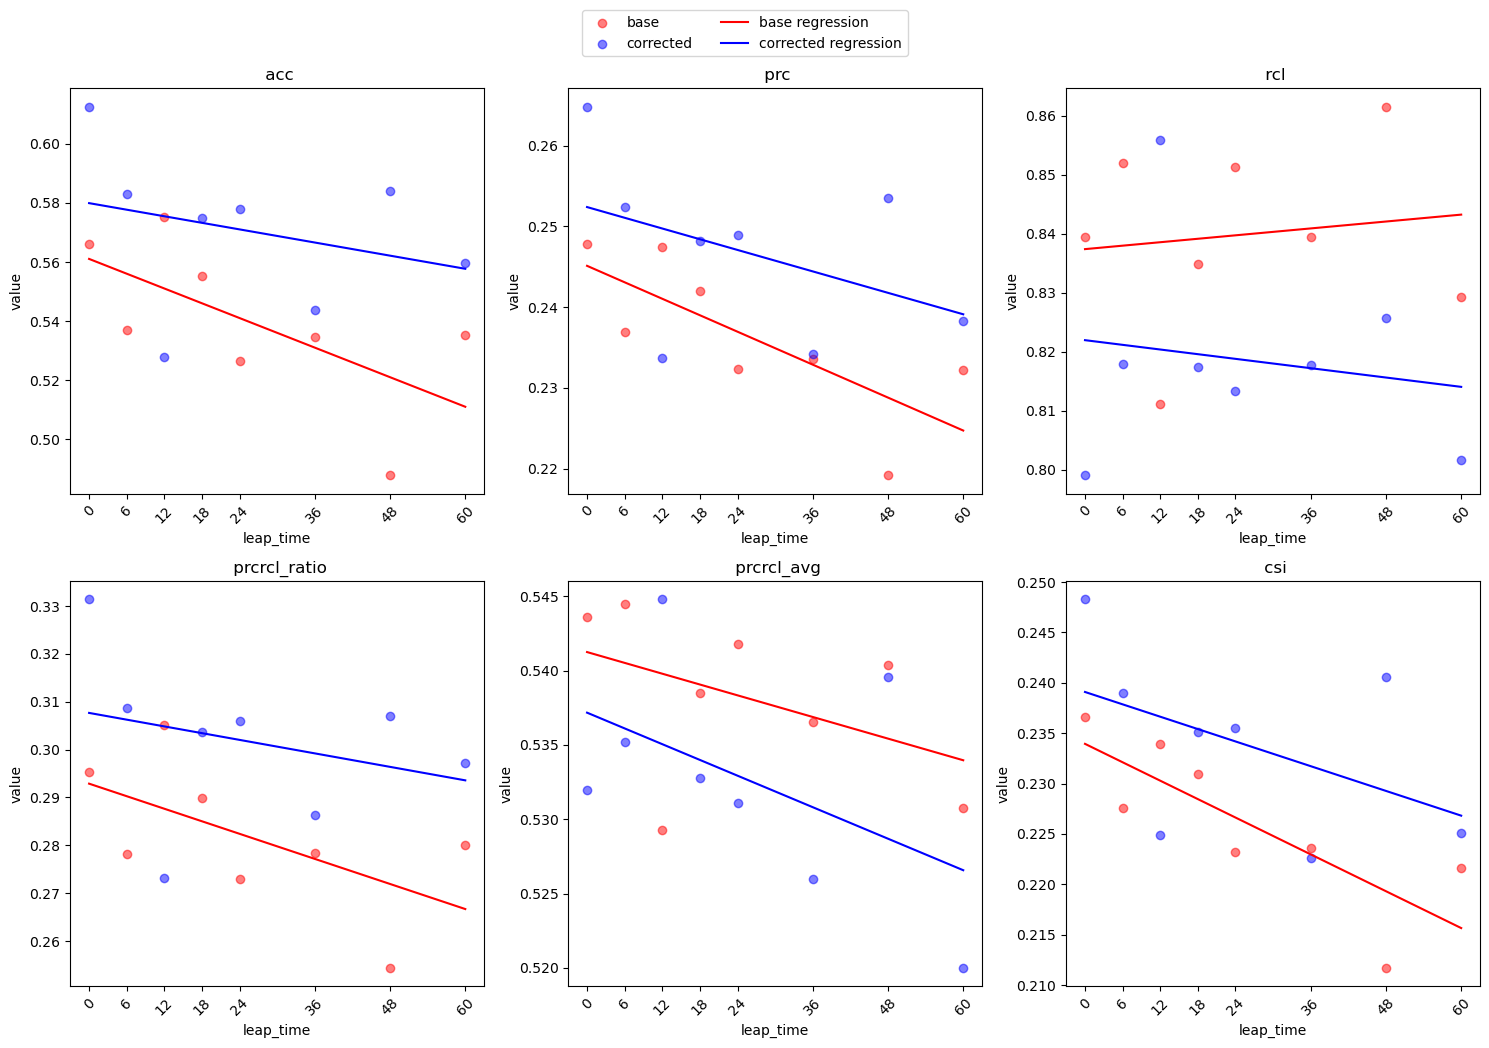

TypeError: something went wrong

In [32]:
quick_results_testing(total_metric_dict)

In [57]:
saving_suffix = '5'

data_dicts = []
for station_dict in dict_list:
    for key, value in station_dict.items():
        data_dicts.append({'station_index': key, **value})

df = pd.DataFrame(data_dicts)

df.set_index('station_index', inplace=True)
df['station_index'] = df.index.str.extract(r'station_index:(\d+)').values.astype(int)
df['leap_time'] = df.index.str.extract(r'leap_time:(\d+)').values.astype(int)
df['tensor_type'] =  df.index.str.extract(r'tensor_type:(\w+)').values.astype(str)
df['station_id'] = df.station_index.map(result_dict)

df.to_csv(f'leaps_metrics_0back_{saving_suffix}.csv')

import pickle 

with open(f'leaps_metrics_total_0back_{saving_suffix}.pkl', 'wb') as f:
    pickle.dump(total_metric_dict, f)
    
concatenated_df_base = pd.concat(base_list)
concatenated_df_corrected = pd.concat(corrected_list)
concatenated_df_base.to_csv(f'base_seasonal_0timeback_{saving_suffix}.csv')
concatenated_df_corrected.to_csv(f'corrected_seasonal_0timeback_{saving_suffix}.csv')

In [29]:
def plot_running_loss_grids(loss_data_list):
    
    
    '''
    plotting running loss in a grid
    
    '''
    import math
    num_plots = len(loss_data_list)
    num_cols = math.ceil(math.sqrt(num_plots))
    num_rows = math.ceil(num_plots / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))
    axs = axs.ravel()  # Flatten the axs array in case it's a 2D array

    for i, (train_loss, val_loss) in enumerate(loss_data_list):
        ax = axs[i]
        ax.plot(train_loss, label='Train Loss')
        ax.plot(val_loss, label='Validation Loss')
        ax.set_title(f'Training and Validation Loss (Tuple {i+1})')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    # Hide any unused subplots
    for i in range(num_plots, num_rows*num_cols):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [30]:
def plot_cm(ground_truth_test, predictions_test, reduce=True ,normalize=False):
    
    '''
        plotting confusion matrix
    '''
    
    reduce_matrix = lambda matrix:matrix[1:, 1:]
    
    labels_to_use = [0, 1 , 2 ,3 ,4 ,5 ,6, 7, 8, 9, 10]
    confusion_mat = confusion_matrix(ground_truth_test, predictions_test)
    if reduce:
        confusion_mat = reduce_matrix(confusion_mat)
        labels_to_use = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10]
#     confusion_mat = remove_first_row_from_confusion_matrix(confusion_mat)
    if normalize:
        cmn = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels_to_use[:cmn.shape[0]], yticklabels=labels_to_use[:cmn.shape[0]])
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
    else:
        cmn = confusion_mat
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(cmn, annot=True, fmt='.0f', xticklabels=labels_to_use[:cmn.shape[0]], yticklabels=labels_to_use[:cmn.shape[0]])
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

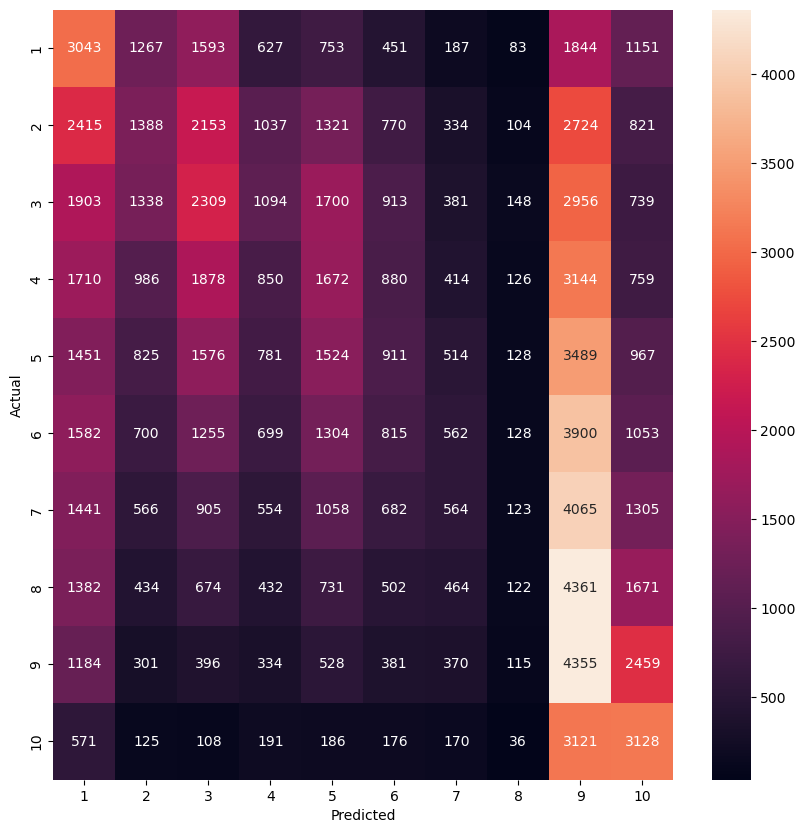

In [43]:
plot_cm(base_total_ground_truth, base_total_predictions,reduce=True, normalize=False)

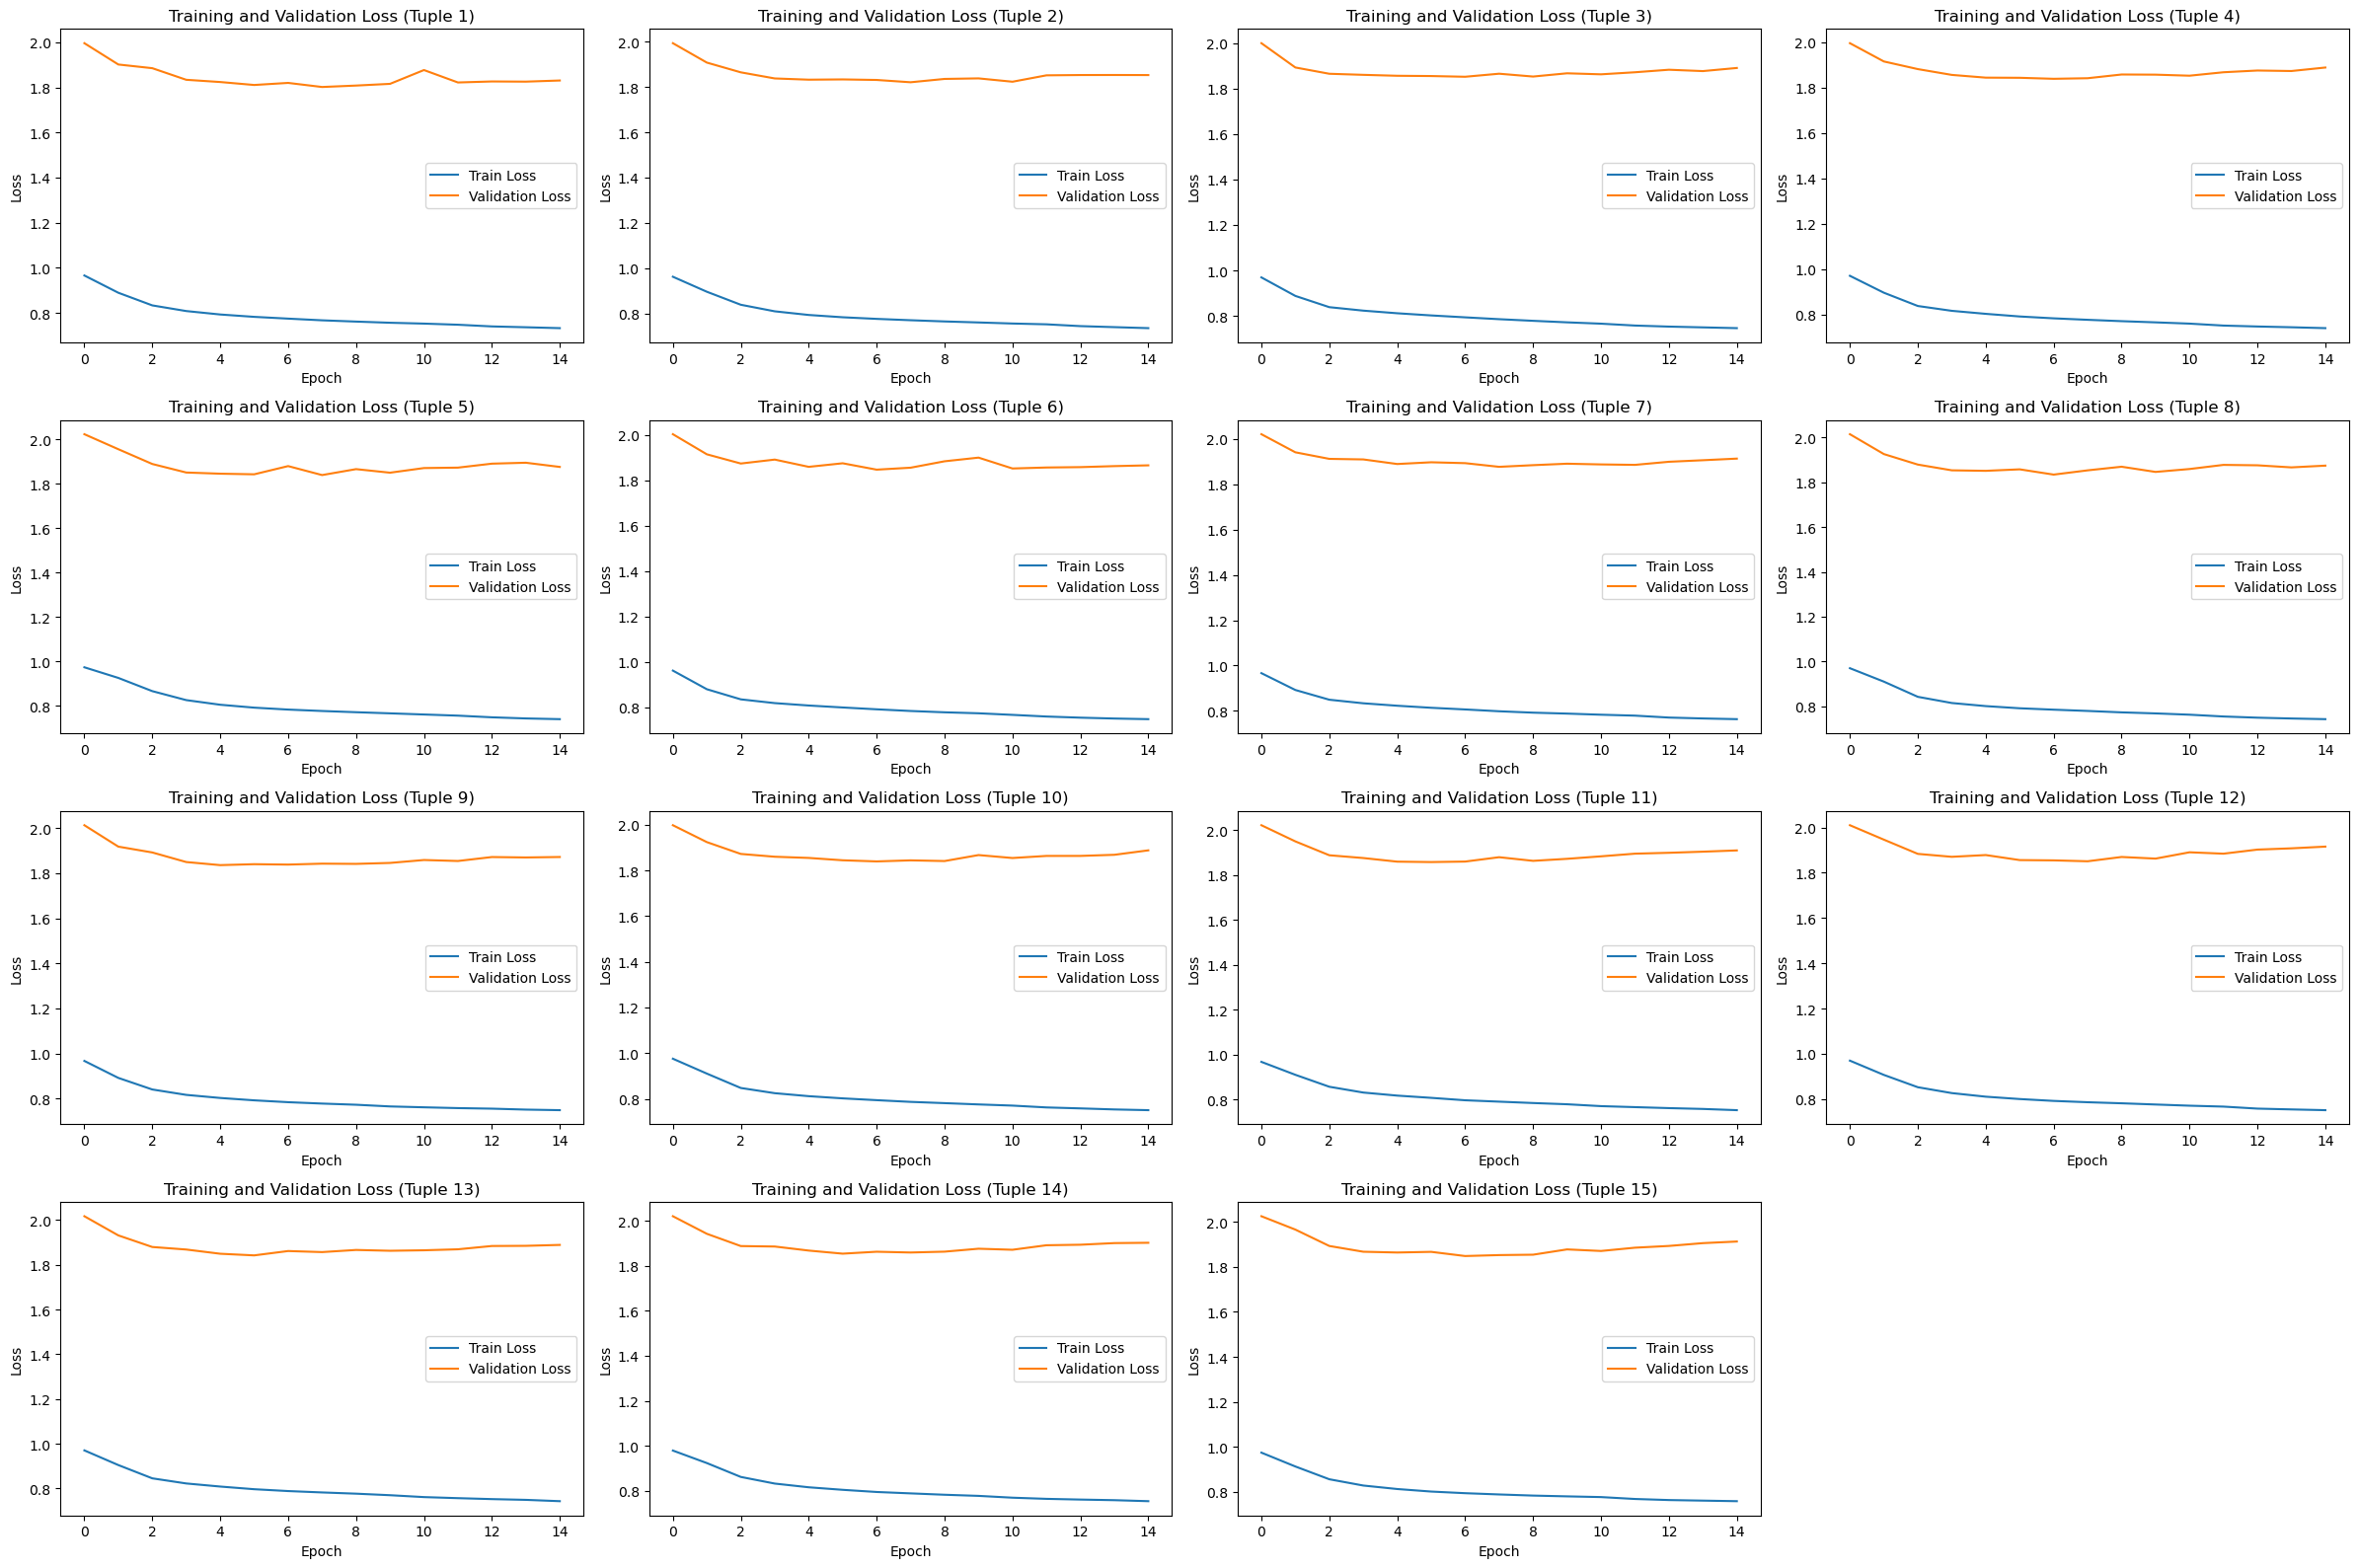

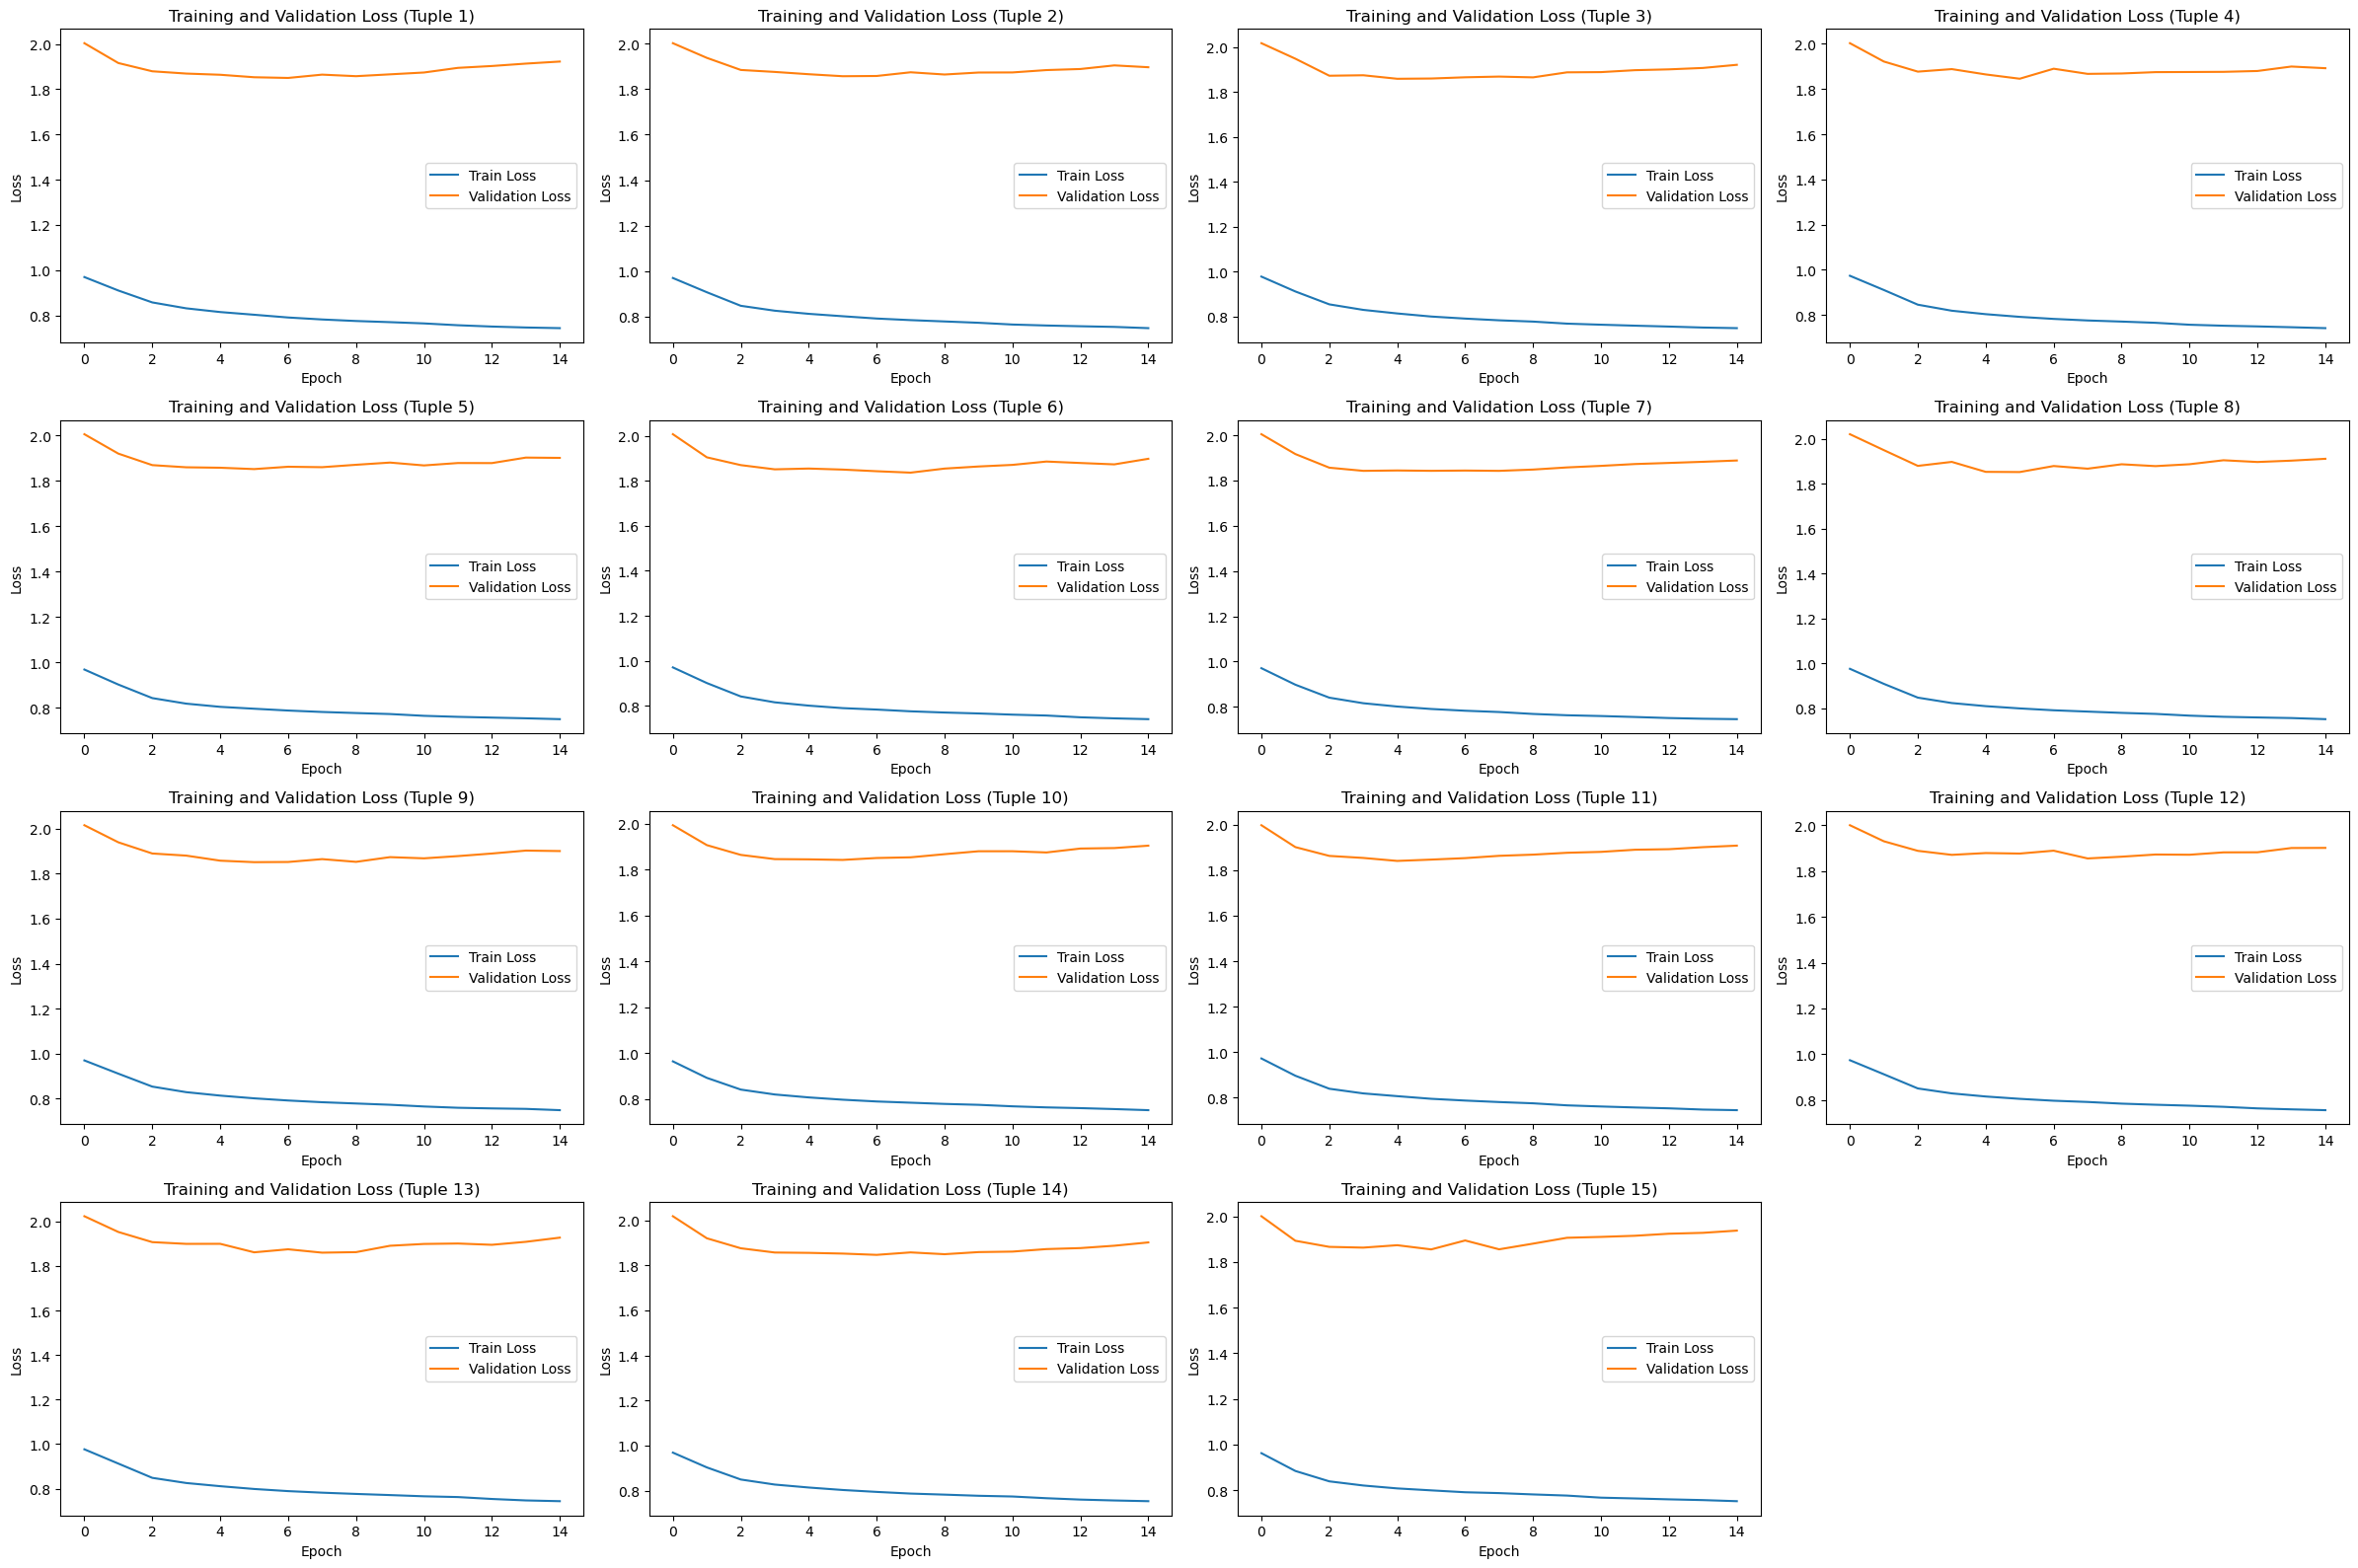

In [84]:
plot_running_loss_grids(list_of_corrected_running_loss)
plot_running_loss_grids(list_of_base_running_loss)

In [64]:
 tensor_data=torch.load("/home/labs/rudich/gavriel/pm_10/data_til_01.2015/new_data_pm10_cams.pkl")

In [81]:
meta_data = torch.load("/home/labs/rudich/ronsar/CAMS_forecasts/gavriel_meta.pkl")

In [84]:
meta_data[]

{'latitude': array([50. , 49.6, 49.2, 48.8, 48.4, 48. , 47.6, 47.2, 46.8, 46.4, 46. ,
        45.6, 45.2, 44.8, 44.4, 44. , 43.6, 43.2, 42.8, 42.4, 42. , 41.6,
        41.2, 40.8, 40.4, 40. , 39.6, 39.2, 38.8, 38.4, 38. , 37.6, 37.2,
        36.8, 36.4, 36. , 35.6, 35.2, 34.8, 34.4, 34. , 33.6, 33.2, 32.8,
        32.4, 32. , 31.6, 31.2, 30.8, 30.4, 30. , 29.6, 29.2, 28.8, 28.4,
        28. , 27.6, 27.2, 26.8, 26.4, 26. , 25.6, 25.2, 24.8, 24.4, 24. ,
        23.6, 23.2, 22.8, 22.4, 22. , 21.6, 21.2, 20.8, 20.4, 20. , 19.6,
        19.2, 18.8, 18.4, 18. , 17.6, 17.2, 16.8, 16.4, 16. , 15.6, 15.2,
        14.8, 14.4, 14. , 13.6, 13.2, 12.8, 12.4, 12. , 11.6, 11.2, 10.8,
        10.4, 10. ], dtype=float32),
 'longitude': array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
        13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 

# Cams Forcast vs ground Truth 

In [58]:
def get_cams_forecast_pred(station,meta_data=None,tensor_data=None,load_tensor_forecast_pm10=False, israel_data=False):
    try:
        import xarray as xr
    except:
        print("download with conda xarray")
    #caculate the distance for each station and see the cordinats 
    #then we will take the cordinates that is best for each station
    #then for each station with the right cordinates and for each day and leadtime we will return the pm
    if load_tensor_forecast_pm10==True:
        tensor_data=torch.load("/home/labs/rudich/gavriel/pm_10/data_til_01.2015/new_data_pm10_cams.pkl")
        meta_data=torch.load("/home/labs/rudich/ronsar/CAMS_forecasts/gavriel_meta.pkl")
    list_pm=[]
    lat_lon_station={}
    meta_data_pm={}
    tensor_lat=torch.tensor(meta_data['latitude'])
    tensor_lon=torch.tensor(meta_data['longitude'])
    #implement without the matrix
    for i in range(len(station)):
        station_id=torch.tensor(station['stn_id'].loc[i])
        lat=torch.tensor(station['lat'].loc[i])
        lon=torch.tensor(station['lon'].loc[i])
        min_lat=torch.argmin(abs(tensor_lat-lat)).item()
        min_lon=torch.argmin(abs(tensor_lon-lon)).item()
        lat_lon_station[i]=[min_lat,min_lon]

    #THEN:
    for i in range((len(station))):
        list_pm.append(tensor_data[:,:,lat_lon_station[i][0],lat_lon_station[i][1]])
    tensor3d_pm=torch.stack(list_pm)

    #META_DATA:
    meta_data_pm["lead_time"]=[x for x in range(109) if x%3==0]
    meta_data_pm["latitude"]=meta_data["latitude"]
    meta_data_pm["longitude"]=meta_data['longitude']
    meta_data_pm["station_lan_lon"]=lat_lon_station
    meta_data_pm["timestamp"]=meta_data["timestamp"]
    
    if israel_data:
        meta_data_pm["station_id_name"]=station['stn_name']
    
    return tensor3d_pm,meta_data_pm


In [59]:
def get_metrics_binar2(ground_truth,predicted,labels=[1,2],smallest_event_level=None,return_matrix=False, o_p=False):
    
    o=ground_truth.copy()

    if type(predicted)!=np.ndarray:

        p =  predicted.detach().cpu().numpy().astype('int64')
    else:
        p = predicted
    if smallest_event_level is not None: #added change, label the others as 1, not quite clear why it wasnt the case

        
        o = np.where(o == 0, 0, np.where(o < smallest_event_level, 1, 2))
#         p = np.where(p == 0, 0, np.where(p < smallest_event_level, 1, 2))
        
        if np.all(o == 0):
            return [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,]
    
    
    tn, fp, fn, tp = confusion_matrix(o,p,labels=labels).ravel()
    acc = (tp+tn)/(tp+fp+tn+fn)
    if tp+fp==0:
        prc = np.nan
    else:
        prc = tp/(tp+fp)
    if tp+fn==0:
        rcl = np.nan
    else:
        rcl = tp/(tp+fn)
    if rcl==np.nan or prc==np.nan or rcl==0:
        prcrcl_ratio = np.nan
        prcrcl_avg = np.nan
    else:
        prcrcl_ratio = prc/rcl
        prcrcl_avg = (prc+rcl)/2
    if tp+fp+fn==0:
        csi = np.nan
    else:
        csi = tp/(tp+fp+fn)
    
    if return_matrix:
        return [acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi], confusion_matrix(o,p,labels=labels)
    
    if o_p:
        return o, p

    return [acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi]       

In [60]:
 def seasons_forcast(GT, Cams_F, timestamps_list, smallest_event_level,num_stations=38):
        def get_season(month):
            if 3 <= month <= 5:
                return 'spring'
            elif 6 <= month <= 8:
                return 'summer'
            elif 9 <= month <= 11:
                return 'fall'
            else:
                return 'winter'

        predictions_test_time_station =Cams_F.reshape(-1, num_stations)
        ground_truth_test_time_station = GT.reshape(-1, num_stations)

        results_df = pd.DataFrame(index=timestamps_list, columns=['accuracy','precision', 'recall', 'prcrcl_ratio','prcrcl_avg', 'csi'])

        # Loop over timestamps and compute metrics
        for idx, timestamp in enumerate(timestamps_list):

            metrics = get_metrics_binar2(ground_truth_test_time_station[idx],predictions_test_time_station[idx],labels=[1,2],smallest_event_level=smallest_event_level)
            results_df.loc[timestamp] = metrics
        results_df['index_in_timestamp_list'] = range(0, len(timestamps_list))
        results_df = results_df.sort_index()



        results_df.index = pd.to_datetime(results_df.index)
        results_df['year'] = results_df.index.year
        results_df['month'] = results_df.index.month
        results_df['season'] = results_df['month'].apply(get_season)

        return results_df

In [64]:
def get_metrics_using_forcast(meta_data_cams_forcast, CAMS_tensor , test_timestamps, lead_time, ground_truth_data=None, test_loader=None,
                              num_stations=38,smallest_event_level=9,classification=True, threshold=55.056606666):
                              
    
    def match_obs_times_to_forcast(test_timelist, leap_time, unit='h'):
        return [x + pd.Timedelta(leap_time,unit) for x in test_timelist]

    
    def loader_iterator(test_loader,matching_times_indices):
        '''
        Requirments : batch size should be 1
        
        '''
        all_labels = []
        
        for i, (inputs, labels) in enumerate(testloader):
            
            if inputs.shape[0] != 1:
                raise ValueError('batch size is not supported')
            if i in matching_times_indices:
                labels = labels.to(device)
                all_labels.append(labels.cpu().numpy())
     
        return np.concatenate(all_labels)
        
    def get_indices(list1,list2):

        df1 = pd.DataFrame({'Timestamp': list1})
        df2 = pd.DataFrame({'Timestamp': list2})

        merged_df = pd.merge(df1.reset_index(), df2.reset_index(), on='Timestamp', how='inner', suffixes=('_list1', '_list2'))

        indices_list1 = merged_df['index_list1'].tolist()
        indices_list2 = merged_df['index_list2'].tolist()

        if len(indices_list1) != len(indices_list2):
            raise ValueError('list not matching')

        return indices_list1, indices_list2, merged_df['Timestamp'].values
    
    def seasons_forcast(GT, Cams_F, timestamps_list, smallest_event_level,num_stations=38):
        def get_season(month):
            if 3 <= month <= 5:
                return 'spring'
            elif 6 <= month <= 8:
                return 'summer'
            elif 9 <= month <= 11:
                return 'fall'
            else:
                return 'winter'

        predictions_test_time_station =Cams_F.reshape(-1, num_stations)
        ground_truth_test_time_station = GT.reshape(-1, num_stations)

        results_df = pd.DataFrame(index=timestamps_list, columns=['accuracy','precision', 'recall', 'prcrcl_ratio','prcrcl_avg', 'csi'])

        
        for idx, timestamp in enumerate(timestamps_list):

            metrics = get_metrics_binar2(ground_truth_test_time_station[idx],predictions_test_time_station[idx],labels=[1,2],smallest_event_level=smallest_event_level)
            results_df.loc[timestamp] = metrics
        results_df['index_in_timestamp_list'] = range(0, len(timestamps_list))
        results_df = results_df.sort_index()



        results_df.index = pd.to_datetime(results_df.index)
        results_df['year'] = results_df.index.year
        results_df['month'] = results_df.index.month
        results_df['season'] = results_df['month'].apply(get_season)

        return results_df
    
    

    def test_stations_cams_forcast(ground_truth, predictions, smallest_event_level=9):
        station_pred_label_dict = {}  

        for station_idx in range(ground_truth.shape[1]):
            station_labels = ground_truth[:, station_idx]
            station_predictions = predictions[:, station_idx]


            if station_idx not in station_pred_label_dict:
                station_pred_label_dict[station_idx] = {'predictions': [], 'labels': []}
            station_pred_label_dict[station_idx]['predictions'].extend(station_predictions)
            station_pred_label_dict[station_idx]['labels'].extend(station_labels)

        stations_metrics = {}

        for station_idx, metrics in station_pred_label_dict.items():
            station_predictions = np.array(metrics['predictions'])
            station_labels = np.array(metrics['labels'])
            acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi = get_metrics_binar2(station_labels,
                                                                             station_predictions, labels=[1, 2],
                                                                             smallest_event_level=smallest_event_level)
            stations_metrics[station_idx] = {'acc': acc, 'prc': prc, 'rcl': rcl,
                                             'prcrcl_ratio': prcrcl_ratio, 'prcrcl_avg': prcrcl_avg,
                                             'csi': csi}
        return stations_metrics

        

        
        
    moved_test_timestamps = match_obs_times_to_forcast(test_timestamps,lead_time)

    forcast_indices, test_indices, timestamps_lst = get_indices(meta_data_cams_forcast['timestamp'],moved_test_timestamps)
    Cams_forcast_reshaped = rearrange(CAMS_tensor, 's t l -> t s l') 
    leap_index = meta_data_cams_forcast['lead_time'].index(lead_time)
    
 
    Cams_forcast_subset = Cams_forcast_reshaped[forcast_indices,:,leap_index]
    
    
    if test_loader != None:
        ground_truth = loader_iterator(test_loader,test_indices)
    else:
        ground_truth = ground_truth_data[test_indices,:]
        
    ###########
    # return Cams_forcast_subset, ground_truth
        
    ##########     
      
    if classification:
        # 55.056606666 # thresholds[7].item()
       
        #dealing with nan/negetive number -> assigning to 0
        Cams_forcast_subset[Cams_forcast_subset <= 0] = np.nan
        nan_mask = torch.isnan(Cams_forcast_subset)
        Cams_forcast_subset[nan_mask] = 0
        
        mask = (Cams_forcast_subset < threshold) & (Cams_forcast_subset > 0) 
        Cams_forcast_subset = torch.where(mask, 1, Cams_forcast_subset)
        Cams_forcast_subset[Cams_forcast_subset >= threshold] = 2
        
   
        
    
    cams_numpy = Cams_forcast_subset.detach().cpu().numpy()
    # print(f'forcast nan values {np.sum(np.isnan(cams_numpy))},ground_truth nan values {np.sum(np.isnan(ground_truth))} ')
    print(f'forcast shape {cams_numpy.shape} , ground_truth shape {ground_truth.shape}')

    # print(ground_truth.flatten())
    # print('################')
    # print(cams_numpy.flatten())
    
    total_metric = get_metrics_binar2(ground_truth.flatten(),cams_numpy.flatten(),labels=[1,2],smallest_event_level=smallest_event_level)
    
    seasons_df = seasons_forcast(ground_truth, cams_numpy, timestamps_lst, smallest_event_level=smallest_event_level,num_stations=num_stations)
    seasons_df['leap_time'] = lead_time
   
    stations_metrics = test_stations_cams_forcast(ground_truth, cams_numpy, smallest_event_level=smallest_event_level)

    # return total_metric
    return total_metric, seasons_df, stations_metrics ,  ground_truth, Cams_forcast_subset.detach().cpu().numpy(), timestamps_lst
    
    
    

In [62]:
coords = pd.read_csv('coords_greecee.csv',index_col=0)
list_of_stations = df_categories.drop('time',axis=1).columns.tolist()
list_of_stations = [int(x) for x in list_of_stations]
coords = coords.query('station_id in @list_of_stations')
coords = (coords
         .reset_index(drop=True)
         .drop('stn_id',axis=1)
         .pipe(lambda d: d.rename({'station_id':'stn_id'},axis=1))
         )

station_ids_list = df_categories.drop('time',axis=1).columns.tolist()

station_order = {stn_id: index for index, stn_id in enumerate(station_ids_list)}


coords['order'] = coords['stn_id'].astype('str').map(station_order)


coords = coords.sort_values(by='order')
coords = coords.reset_index(drop=True)

Cams_forcast_raw, meta_data_cams_forcast = get_cams_forecast_pred(coords, load_tensor_forecast_pm10=True)

Cams_forcast = Cams_forcast_raw.clone()

In [68]:

leap_times_list = [0, 3, 6, 9 , 12 ,15 , 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72]
lookback = 0
without_correction = True
time_split = True
cams_forcast_total_dict = {}
dict_list_forcast = []
seasons_df_list = []
num_stations=38
smallest_event_level=9
shared_times_list = []
GT_list = []
CF_list = []

# for j in tqdm(range(0,Cams_forcast.shape[2])):
with tqdm(total=len(leap_times_list)) as pbar:
    for leap in leap_times_list:
        # leap = leap_times_list[j]
        trainloader, validationloader, testloader, input_shape, tr_indices, validation_indices , test_indices,time_list = create_dataset(final_tensor, df_categories,
                                                                                                                                         time_to_predict=leap, lookback_num=lookback,
                                                                                                                                         without_correction=without_correction, batch_size=1,
                                                                                                                                         time_split=time_split,verbose=False)

        if time_split:
            tr_indices, validation_indices , test_indices = fix_indices(tr_indices, validation_indices , test_indices, time_list)
            
            
            
            
            
        total_metrics, seasons_df, stations_metrics,  GT, CF, TL = get_metrics_using_forcast(meta_data_cams_forcast,CAMS_tensor=Cams_forcast_raw, test_timestamps=test_indices,lead_time=leap, num_stations=num_stations,
                                                                                 smallest_event_level=smallest_event_level,test_loader=testloader,classification=True)
                                                                               



        # total_metrics, seasons_df, stations_metrics , GT, CF, TL = get_metrics_using_forcast(meta_data_cams_forcast, Cams_forcast_raw, test_indices,lead_time=leap, num_stations=num_stations,
                                                                                 # smallest_event_level=smallest_event_level,test_loader=testloader)

        cams_forcast_total_dict[str(leap)+'_CamsForcast'] = total_metrics

        stations_dict = {'station_index:' + str(key) + ' leap_time:' + str(leap) + 
                       ' tensor_type:'+'_CamsForcast': value for key, value in stations_metrics.items()}
        dict_list_forcast.append(stations_dict)
        seasons_df_list.append(seasons_df)
        
        
        GT_list.append(GT)
        CF_list.append(CF)
        shared_times_list.append(TL)
        
        pbar.update(1)



  0%|          | 0/25 [00:00<?, ?it/s]

forcast shape (1172, 38) , ground_truth shape (1172, 38)


  4%|▍         | 1/25 [00:37<14:53, 37.24s/it]

forcast shape (1159, 38) , ground_truth shape (1159, 38)


  8%|▊         | 2/25 [01:12<13:48, 36.03s/it]

forcast shape (1172, 38) , ground_truth shape (1172, 38)


 12%|█▏        | 3/25 [01:47<12:59, 35.42s/it]

forcast shape (1161, 38) , ground_truth shape (1161, 38)


 16%|█▌        | 4/25 [02:20<12:05, 34.57s/it]

forcast shape (1172, 38) , ground_truth shape (1172, 38)


 20%|██        | 5/25 [02:53<11:17, 33.87s/it]

forcast shape (1159, 38) , ground_truth shape (1159, 38)


 24%|██▍       | 6/25 [03:25<10:33, 33.34s/it]

forcast shape (1172, 38) , ground_truth shape (1172, 38)


 28%|██▊       | 7/25 [03:57<09:55, 33.08s/it]

forcast shape (1161, 38) , ground_truth shape (1161, 38)


 32%|███▏      | 8/25 [04:33<09:34, 33.78s/it]

forcast shape (1172, 38) , ground_truth shape (1172, 38)


 36%|███▌      | 9/25 [05:11<09:25, 35.32s/it]

forcast shape (1159, 38) , ground_truth shape (1159, 38)


 40%|████      | 10/25 [05:50<09:05, 36.36s/it]

forcast shape (1172, 38) , ground_truth shape (1172, 38)


 44%|████▍     | 11/25 [06:25<08:23, 35.98s/it]

forcast shape (1161, 38) , ground_truth shape (1161, 38)


 48%|████▊     | 12/25 [07:03<07:56, 36.69s/it]

forcast shape (1172, 38) , ground_truth shape (1172, 38)


 52%|█████▏    | 13/25 [07:38<07:12, 36.05s/it]

forcast shape (1158, 38) , ground_truth shape (1158, 38)


 56%|█████▌    | 14/25 [08:11<06:27, 35.21s/it]

forcast shape (1172, 38) , ground_truth shape (1172, 38)


 60%|██████    | 15/25 [08:46<05:51, 35.12s/it]

forcast shape (1160, 38) , ground_truth shape (1160, 38)


 64%|██████▍   | 16/25 [09:19<05:10, 34.45s/it]

forcast shape (1172, 38) , ground_truth shape (1172, 38)


 68%|██████▊   | 17/25 [09:53<04:35, 34.42s/it]

forcast shape (1158, 38) , ground_truth shape (1158, 38)


 72%|███████▏  | 18/25 [10:27<03:59, 34.26s/it]

forcast shape (1172, 38) , ground_truth shape (1172, 38)


 76%|███████▌  | 19/25 [11:01<03:24, 34.09s/it]

forcast shape (1160, 38) , ground_truth shape (1160, 38)


 80%|████████  | 20/25 [11:35<02:50, 34.10s/it]

forcast shape (1172, 38) , ground_truth shape (1172, 38)


 84%|████████▍ | 21/25 [12:10<02:16, 34.18s/it]

forcast shape (1158, 38) , ground_truth shape (1158, 38)


 88%|████████▊ | 22/25 [12:44<01:43, 34.40s/it]

forcast shape (1172, 38) , ground_truth shape (1172, 38)


 92%|█████████▏| 23/25 [13:19<01:09, 34.55s/it]

forcast shape (1160, 38) , ground_truth shape (1160, 38)


 96%|█████████▌| 24/25 [13:52<00:34, 34.10s/it]

forcast shape (1173, 38) , ground_truth shape (1173, 38)


100%|██████████| 25/25 [14:26<00:00, 34.65s/it]


In [70]:
data_dicts = []
for station_dict in dict_list_forcast:
    for key, value in station_dict.items():
        data_dicts.append({'station_index': key, **value})

df = pd.DataFrame(data_dicts)

df.set_index('station_index', inplace=True)
df['station_index'] = df.index.str.extract(r'station_index:(\d+)').values.astype(int)
df['leap_time'] = df.index.str.extract(r'leap_time:(\d+)').values.astype(int)
df['tensor_type'] =  df.index.str.extract(r'tensor_type:(\w+)').values.astype(str)
df['station_id'] = df.station_index.map(result_dict)

df.to_csv('leaps_metrics_forcast.csv')

with open('leaps_metrics_total_cams_forcast.pkl', 'wb') as f:
    pickle.dump(cams_forcast_total_dict, f)

cams_seasonal_df = pd.concat(seasons_df_list)

cams_seasonal_df.to_csv('cams_seasonal_df.csv')

## Looking at some plots

In [35]:
def filter_timestamps(timestamps, year=None, start_year=None, end_year=None):
    filtered_indices = []

    for i, timestamp in enumerate(timestamps):
        timestamp = pd.Timestamp(timestamp)
        timestamp_year = timestamp.year
        
        if year is not None and timestamp_year == year:
            filtered_indices.append(i)
            
        if start_year is not None and end_year is not None:
            if start_year <= timestamp_year <= end_year:
                filtered_indices.append(i)
    
    return filtered_indices

In [ ]:
# with open('greecee_pixels.pkl', 'wb') as file:
#     pickle.dump(pixel_coords_list, file)

# with open('greecee_pixels.pkl', 'rb') as file:
#     pixel_coords_list = pickle.load(file)


In [177]:
leap_index = 0
year_to_filter = 2018
station_index = 1
column_indices = [0, station_index+1]  


stn = greecee_pm.iloc[:,[0, station_index+1]]
stn = stn.assign(time=pd.to_datetime(stn.time))
forcast = CF_list[leap_index][:,station_index]
time_list = shared_times_list[leap_index]

time_indices = filter_timestamps(time_list, year=2019, start_year=None, end_year=None)
subset_times = [pd.Timestamp(time_list[i]) for i in time_indices]
subset_times_series = pd.Series(subset_times,dtype='datetime64[ns, UTC]')

stn_subset =  stn[stn['time'].isin(subset_times_series)]
forcast_subset = forcast[time_indices]

In [204]:
stations_subset = np.random.choice(list(range(38)),num_station_indices)


In [ ]:
df_for_lat_lon = (
      pd.read_csv('extened_test_small.csv')  
      .pipe(lambda d: d.assign(lat_lon_coord = convert_string_to_tuple_list(d['lat_lon_coord'].values.tolist())))
     )

In [ ]:
                


greecee_stations = pd.read_csv('greecee_stations.csv')
stations_list = df_categories.drop('time',axis=1).columns.tolist()
greecee_pm = greecee_stations[['time'] +stations_list]

coords = pd.read_csv('coords_greecee.csv',index_col=0)

subset_stn_list = [int(x) for x in np.array(stations_list)[stations_subset]]

subset_coords = coords.query('station_id in @subset_stn_list')

from scipy.spatial.distance import cdist

pixel_coords = np.array(pixel_coords_list.tolist()).reshape(-1,2)

distances = cdist(subset_coords[['lat', 'lon']], pixel_coords,metric='euclidean')

closest_pixel_indices = np.argmin(distances, axis=1)

list_of_tuples = [tuple(row) for row in  pixel_coords[closest_pixel_indices]]

list_of_strings = [str(x) for x in list_of_tuples] 

results_df = pd.DataFrame({
    'station_id': subset_coords['station_id'],
    'lat_lon_coord': list_of_tuples,

})

final_df = pd.merge(subset_coords, results_df, on='station_id')

In [ ]:
subset_df = df_for_lat_lon[['time', 'lat_lon_coord','pm10']].query('lat_lon_coord in @list_of_tuples')
subset_df = subset_df.assign(time=pd.to_datetime(subset_df.time))
subset_df = subset_df.merge(final_df[['station_id','lat_lon_coord']], on='lat_lon_coord',how='left')

reanylsis = subset_df[subset_df['time'].isin(subset_times_series)]

In [303]:
stn_id = int(stations_list[station_index])

,time,lat_lon_coord,pm10,station_id
95721,2019-05-26 12:00:00+00:00,"(38.0, 23.5)",14.599137,46290
95729,2019-05-27 00:00:00+00:00,"(38.0, 23.5)",22.206443,46290
95737,2019-05-27 12:00:00+00:00,"(38.0, 23.5)",13.103583,46290
95745,2019-05-28 00:00:00+00:00,"(38.0, 23.5)",2.065152,46290
95753,2019-05-28 12:00:00+00:00,"(38.0, 23.5)",47.361855,46290
...,...,...,...,...
99193,2019-12-29 12:00:00+00:00,"(38.0, 23.5)",16.033317,46290
99201,2019-12-30 00:00:00+00:00,"(38.0, 23.5)",5.066379,46290
99209,2019-12-30 12:00:00+00:00,"(38.0, 23.5)",15.418991,46290
99217,2019-12-31 00:00:00+00:00,"(38.0, 23.5)",5.847063,46290


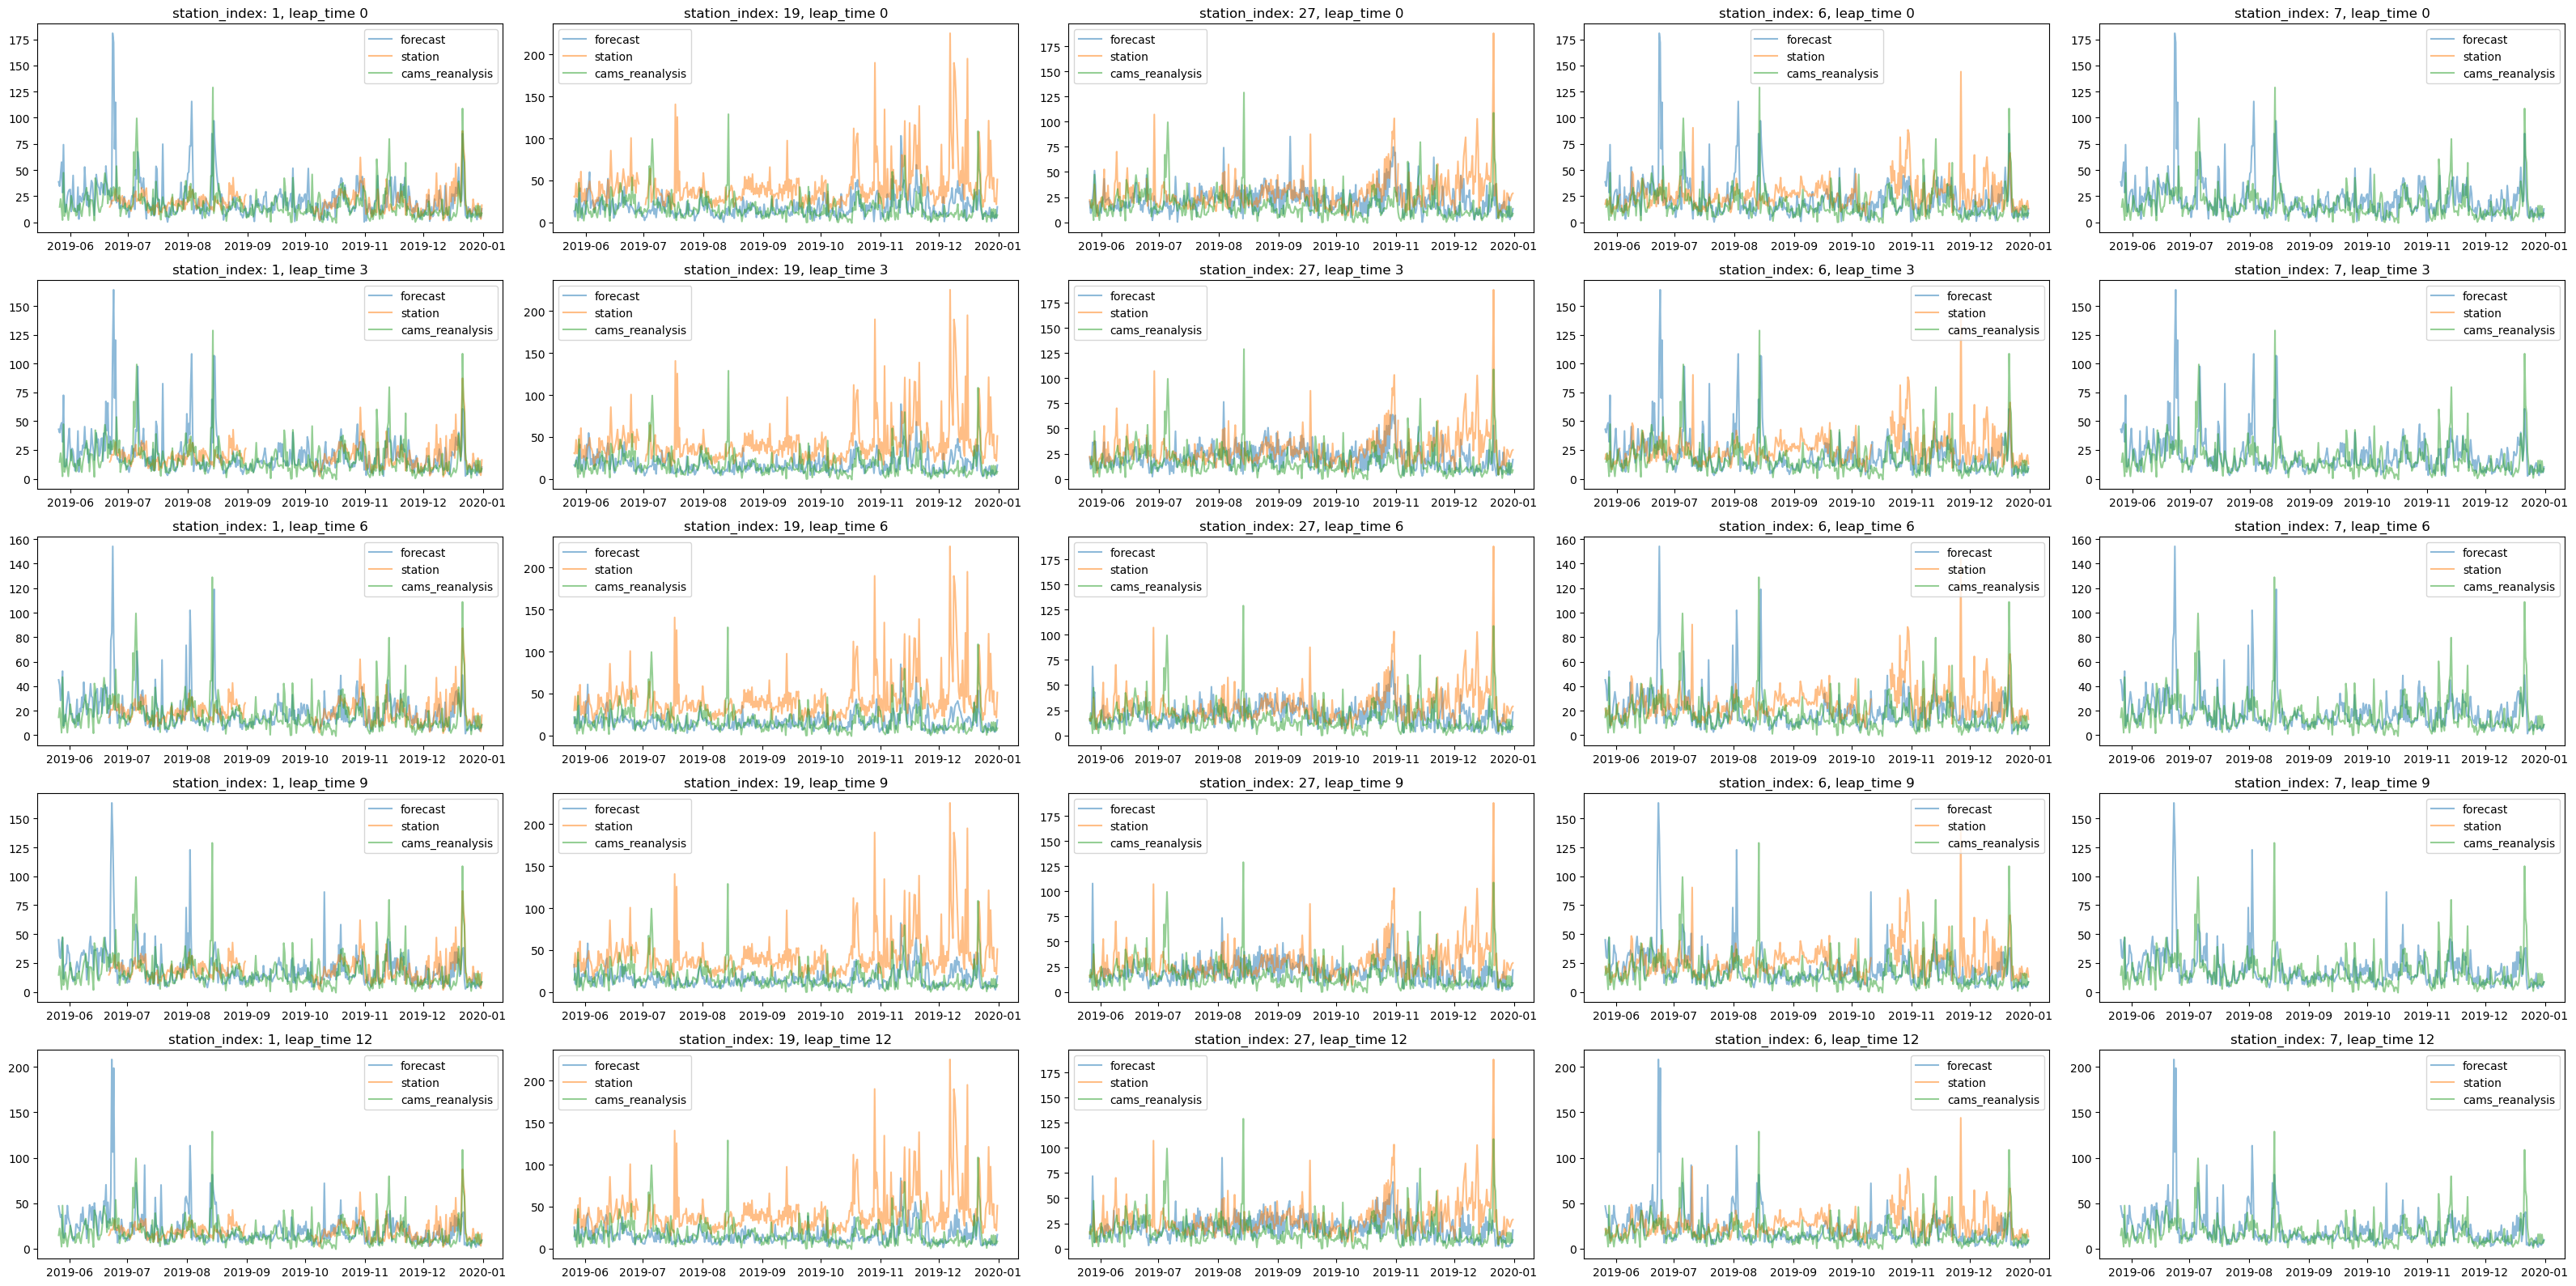

In [306]:
num_leap_indices = 5
num_station_indices = 5

fig, axs = plt.subplots(num_leap_indices, num_station_indices, figsize=(32, 16))


for leap_index in range(num_leap_indices):
    for i,station_index in enumerate(stations_subset):
        
        reanylsis_pixel = reanylsis.query('station_id == @stn_id')

        stn = greecee_pm.iloc[:, [0, station_index + 1]]
        stn = stn.assign(time=pd.to_datetime(stn.time))
        forcast = CF_list[leap_index][:, station_index]
        time_list = shared_times_list[leap_index]
        time_indices = filter_timestamps(time_list, year=2019, start_year=None, end_year=None)
        subset_times = [pd.Timestamp(time_list[i]) for i in time_indices]
        subset_times_series = pd.Series(subset_times, dtype='datetime64[ns, UTC]')
        stn_subset = stn[stn['time'].isin(subset_times_series)]
        forcast_subset = forcast[time_indices]


        ax = axs[leap_index, i]
        ax.plot(subset_times_series, forcast_subset, label='forecast', alpha=0.5)
        ax.plot(stn_subset['time'], stn_subset.iloc[:, 1].values, label='station', alpha=0.5)
        ax.plot(reanylsis_pixel['time'],reanylsis_pixel['pm10'],label='cams_reanalysis',alpha=0.5)
        ax.set_title(f'station_index: {station_index}, leap_time {leap_index * 3}')
        ax.legend()


plt.tight_layout()
plt.savefig('stn_forcast_re.png')
# plt.show()






## Testing israel data

In [156]:
camsf_dir = "/home/labs/rudich/gavriel/pm_10/data_til_01.2015/"
insitu_dir = "/home/labs/rudich/Collaboration/dust_prediction/data/dust_61368_108_2_339/"

camsf_all = torch.load(camsf_dir+"new_data_pm10_cams.pkl")
camsf_all_meta = torch.load("/home/labs/rudich/ronsar/CAMS_forecasts/gavriel_meta.pkl")
camsf_all_timestamps = camsf_all_meta['timestamp']

insitu_all = torch.load(insitu_dir+"dust_61368_108_2_339_full_tensor.pkl")[:,:,0,0]
insitu_all_meta = torch.load(insitu_dir+"dust_61368_108_2_339_metadata.pkl")
insitu_all_timestamps = torch.load(insitu_dir+"dust_61368_108_2_339_full_timestamps.pkl")
insitu_all_stations = pd.read_csv("/home/labs/rudich/Collaboration/dust_prediction/data/stations_coord_lonlat.csv")

# print("camsf_all.shape:", camsf_all.shape, 
#       "\ncamsf_all_timestamps:", camsf_all_timestamps,
#       "\ninsitu_all.shape:", insitu_all.shape,
#       "\ninsitu_all_timestamps:", insitu_all_timestamps,
#       "insitu_all_station:", insitu_all_stations['stn_name'])

In [157]:
def regression_to_classfication_helper(data,threshold=65):
    if data.dtype == torch.float32:
        data = data.detach().cpu().numpy()
    data[data < 0] = np.nan
    data[np.isnan(data)] = 0
    
   
    data[data < threshold] = 1
    data[data >= threshold] = 2
        
    return data
def subset_dict(input_dict, keys_list):
    return {key: input_dict[key] for key in keys_list if key in input_dict}

### subset 30 stations section

In [248]:
Cams_forcast_raw, meta_data_cams_forcast = get_cams_forecast_pred(insitu_all_stations, load_tensor_forecast_pm10=True, israel_data=True)

In [193]:
subset_time = filter_timestamps(meta_data_cams_forcast['timestamp'], year=None, start_year=2000, end_year=2016)
meta_data_cams_forcast['timestamp'] = [meta_data_cams_forcast['timestamp'][x] for x in subset_time]

In [205]:
insitu_30 = insitu_all[:,stn_idx_30]
insitu_30[insitu_30 < 0] = np.nan
insitu_30 = regression_to_classfication_helper(insitu_30,threshold=65)

Cams_forcast_raw[Cams_forcast_raw<0] = np.nan
Cams_forcast_raw[Cams_forcast_raw == 0] = np.nan 
CAMS_30 = Cams_forcast_raw[insitu_all_stations.query('stn_id in @stn_idx_30').index,:]
CAMS_30 = CAMS_30[:,subset_time,:]

In [38]:
insitu_all_numpy = regression_to_classfication_helper(insitu_all[:,insitu_all_stations['stn_id'].values],threshold=65) 
# insitu_all_numpy = regression_to_classfication_helper(insitu_all[:,insitu_all_stations['stn_id'].values],threshold=65) 

In [44]:
result_dict = subset_dict(meta_data_cams_forcast['station_lan_lon'], insitu_all_stations.query('stn_id in @stn_idx_30').index)

In [162]:
 Cams_forcast_raw[insitu_all_stations.query('stn_id in @stn_idx_30').index,:,:].shape

torch.Size([30, 5730, 37])

In [210]:
insitu_30 = insitu_all[:,stn_idx_30]
insitu_30[insitu_30 < 0] = np.nan
insitu_30_one = regression_to_classfication_helper(insitu_30.nanmean(dim=1).unsqueeze(dim=1))

Cams_forcast_raw[Cams_forcast_raw<0] = np.nan
Cams_forcast_raw[Cams_forcast_raw == 0] = np.nan 
CAMS_one = Cams_forcast_raw[insitu_all_stations.query('stn_id in @stn_idx_30').index,:,:].mean(dim=0).unsqueeze(dim=0)
CAMS_one = CAMS_one[:,subset_time,:]

In [496]:
def stations_to_pixels(original_tensor, latlon_dict):
    """
    Converts station-based data to pixel-based data based on latitude and longitude coordinates.

    Args:
    original_tensor (torch.Tensor): Original tensor with shape [stations, timestamps, lead_times].
    latlon_dict (dict): Dictionary mapping station numbers to (lat, lon) coordinates.

    Returns:
    torch.Tensor: New tensor with shape [unique latlon coords, timestamps, lead_times],
                 containing averaged values for each unique latlon coordinate.
    """
    aggregated_values = {}
    aggregated_counts = {}


    for station in range(original_tensor.shape[0]):
        latlon = latlon_dict.get(station)
        if latlon:
            latlon_key = tuple(latlon)  
            if latlon_key not in aggregated_values:
                aggregated_values[latlon_key] = original_tensor[station]
                aggregated_counts[latlon_key] = 1
            else:
                aggregated_values[latlon_key] += original_tensor[station]
                aggregated_counts[latlon_key] += 1


    for latlon_key in aggregated_values:
        aggregated_values[latlon_key] /= aggregated_counts[latlon_key]

  
    unique_latlon_coords = list(aggregated_values.keys())
    new_tensor = torch.stack([aggregated_values[latlon] for latlon in unique_latlon_coords])

    return new_tensor

pixels_cams = stations_to_pixels(Cams_forcast_raw, result_dict)

### leap loop

In [239]:
leap_times_list = [0, 3, 6, 9 , 12 ,15 , 18, 21, 24, 27, 30, 33, 36, 39, 42]
leap_times_list = [0, 3, 6]

cams_forcast_total_dict = {}
dict_list_forcast = []
seasons_df_list = []
num_stations= 1                #insitu_all_numpy.shape[1]

shared_times_list = []
GT_list = []
CF_list = []

raw_list_c = []

with tqdm(total=len(leap_times_list)) as pbar:
    for leap in leap_times_list:
        
#         total_metrics, seasons_df, stations_metrics,  GT, CF, TL = get_metrics_using_forcast(meta_data_cams_forcast,CAMS_tensor=CAMS_one, test_timestamps=insitu_all_timestamps,lead_time=leap, num_stations=num_stations,
#                                                                                  smallest_event_level=None,test_loader=None,classification=True, threshold=65,
#                                                                                 ground_truth_data=insitu_30_one)

#         cams_forcast_total_dict[str(leap)+'_CamsForcast'] = total_metrics

#         stations_dict = {'station_index:' + str(key) + ' leap_time:' + str(leap) + ' tensor_type:'+'_CamsForcast': value for key, value in stations_metrics.items()}
                       
#         dict_list_forcast.append(stations_dict)
#         seasons_df_list.append(seasons_df)
#         GT_list.append(GT)
#         CF_list.append(CF)
#         shared_times_list.append(TL)
        
        C, G = get_metrics_using_forcast(meta_data_cams_forcast,CAMS_tensor=CAMS_one, test_timestamps=insitu_all_timestamps,lead_time=leap, num_stations=num_stations,
                                                                                 smallest_event_level=None,test_loader=None,classification=True, threshold=65,
                                                                                ground_truth_data=insitu_30_one)

        raw_list_c.append(C)
        
        

        pbar.update(1)

   


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.28it/s]


In [212]:
# with open('leaps_metrics_total_cams_forcast_30_stations_israel_onePixel.pkl', 'wb') as f:
#     pickle.dump(cams_forcast_total_dict, f)
# with open('leaps_metrics_total_cams_forcast_30_stations_israel_normal.pkl', 'wb') as f:
#     pickle.dump(cams_forcast_total_dict, f)
# with open('leaps_metrics_total_cams_forcast_30_stations_israel_onePixel_before2017.pkl', 'wb') as f:
#     pickle.dump(cams_forcast_total_dict, f)
# with open('leaps_metrics_total_cams_forcast_30_stations_israel_normal_before2017.pkl', 'wb') as f:
#     pickle.dump(cams_forcast_total_dict, f)

In [213]:
# with open('leaps_metrics_total_cams_forcast_30_stations_israel_normal.pkl', 'rb') as f:
#         stations_30 = pickle.load(f)
# with open('leaps_metrics_total_cams_forcast_30_stations_israel_onePixel.pkl', 'rb') as f:
#         stations_30_pixel = pickle.load(f)
with open('leaps_metrics_total_cams_forcast_30_stations_israel_normal_before2017.pkl', 'rb') as f:
        stations_30 = pickle.load(f)
with open('leaps_metrics_total_cams_forcast_30_stations_israel_onePixel_before2017.pkl', 'rb') as f:
        stations_30_pixel = pickle.load(f)

In [244]:
raw_list_c[0].shape

torch.Size([924, 1])

In [243]:
raw_list_c[1].shape

torch.Size([924, 1])

#### israel plots

In [216]:
df_cams = pd.DataFrame([
    (int(key.split('_')[0]), key.split('_')[1], *values)
    for key, values in stations_30.items()
        ], columns=['index_label', 'data_type', 'acc', 'prc', 'rcl', 'prcrcl_ratio', 'prcrcl_avg', 'csi']
)
df_cams = df_cams.set_index('index_label')
df_cams = df_cams.drop('data_type',axis=1)

df_pixels = pd.DataFrame([
    (int(key.split('_')[0]), key.split('_')[1], *values)
    for key, values in stations_30_pixel.items()
        ], columns=['index_label', 'data_type', 'acc', 'prc', 'rcl', 'prcrcl_ratio', 'prcrcl_avg', 'csi']
)
df_pixels = df_pixels.set_index('index_label')
df_pixels = df_pixels.drop('data_type',axis=1)

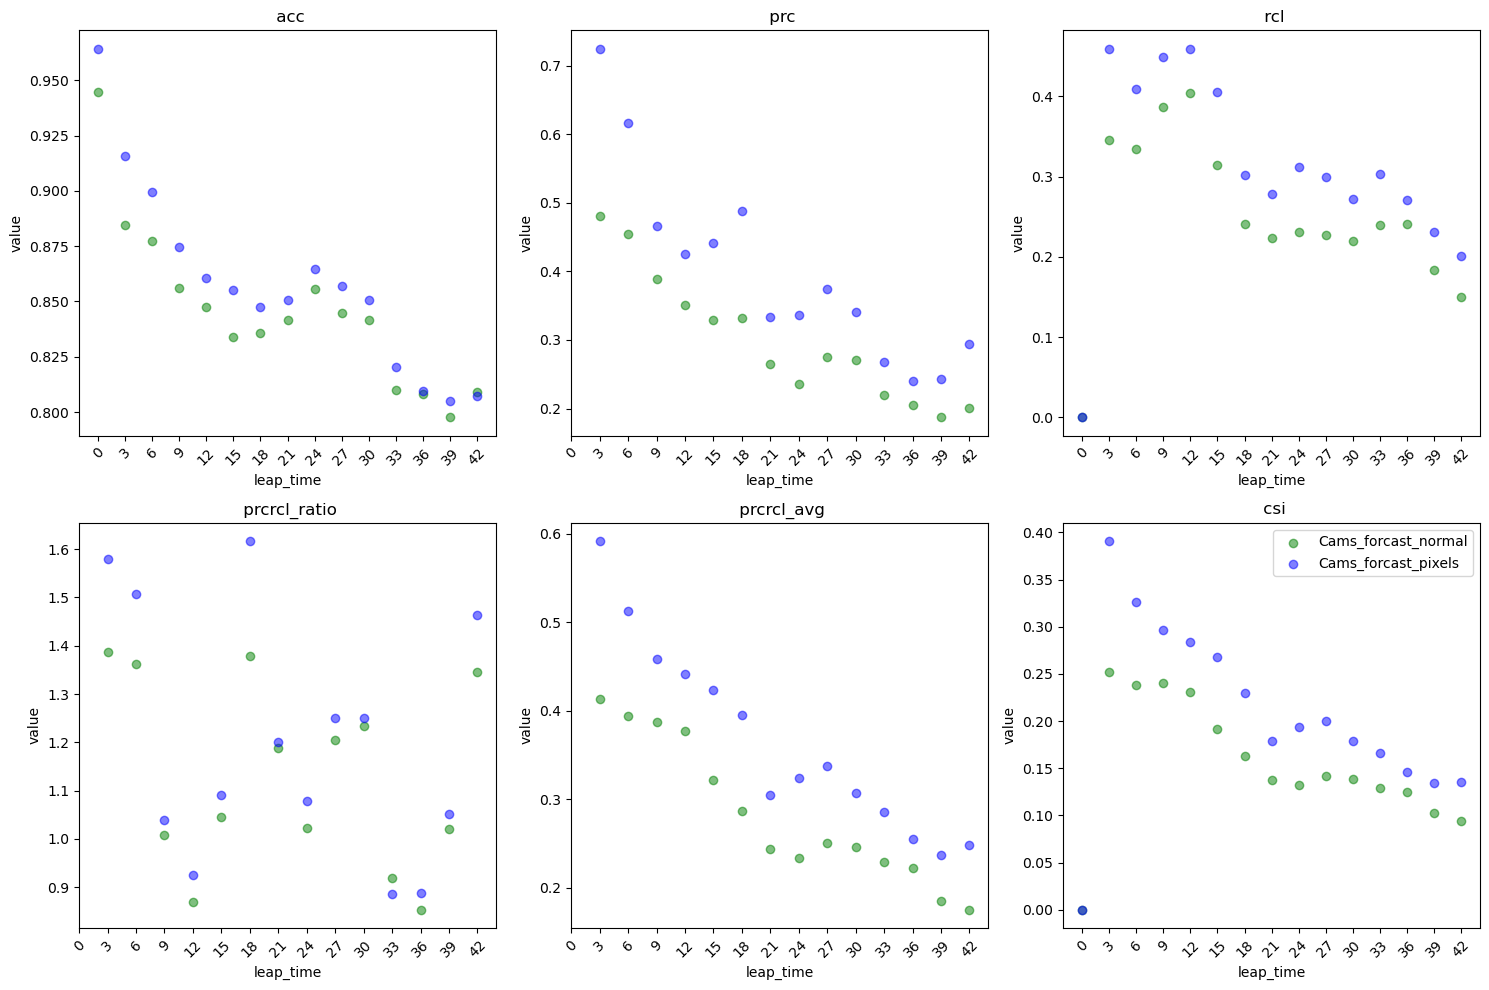

In [217]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
show_regression=True
show_confidence_interval=False
for i, column in enumerate(df_cams.columns):
    ax = axes[i]


    ax.scatter(df_cams.index, df_cams[column], label='Cams_forcast_normal', color='green', alpha=0.5)
    ax.scatter(df_pixels.index, df_pixels[column], label='Cams_forcast_pixels', color='blue', alpha=0.5)

    ax.set_title(f' {column}')
    ax.set_xlabel('leap_time')
    ax.set_ylabel('value')
    ax.set_xticks(df_cams.index)
    ax.set_xticklabels(df_cams.index, rotation=45)


plt.tight_layout()
plt.legend()
plt.show()


In [74]:
unique_values, counts = np.unique(GT, return_counts=True)

# Print unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 1.0, Count: 52958
Value: 2.0, Count: 8410


In [75]:
GT

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

# Corrections vs base maps

In [ ]:
start_index = 2355
length=8
number_list = [start_index + i for i in range(length)]

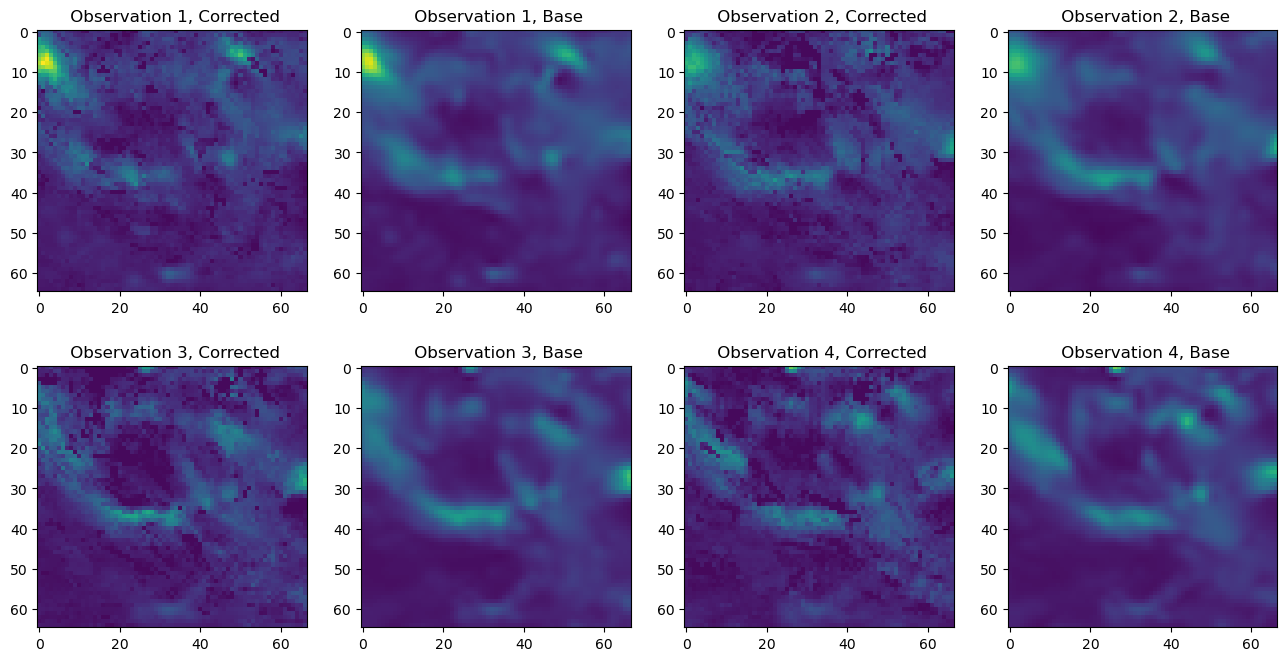

In [172]:
fig, axes = plt.subplots(2,4, figsize=(16,8))
ax = axes.ravel()
start_index = 2355
length=8
number_list = [start_index + i for i in range(length)]
vmax = max(final_tensor[number_list,1,:,:].max(),final_tensor[number_list,0,:,:].max())
vmin = min(final_tensor[number_list,1,:,:].min(),final_tensor[number_list,0,:,:].min())
count = 1
for i in range(0,8,2):

    ax[i].imshow(final_tensor[start_index+i,1,:,:],vmax=vmax,vmin=vmin)
    ax[i].set_title(f' Observation {count}, Corrected')
    ax[i+1].imshow(final_tensor[start_index+i,0,:,:],vmax=vmax,vmin=vmin)
    ax[i+1].set_title(f' Observation {count}, Base')
    count+=1

plt.show()

    


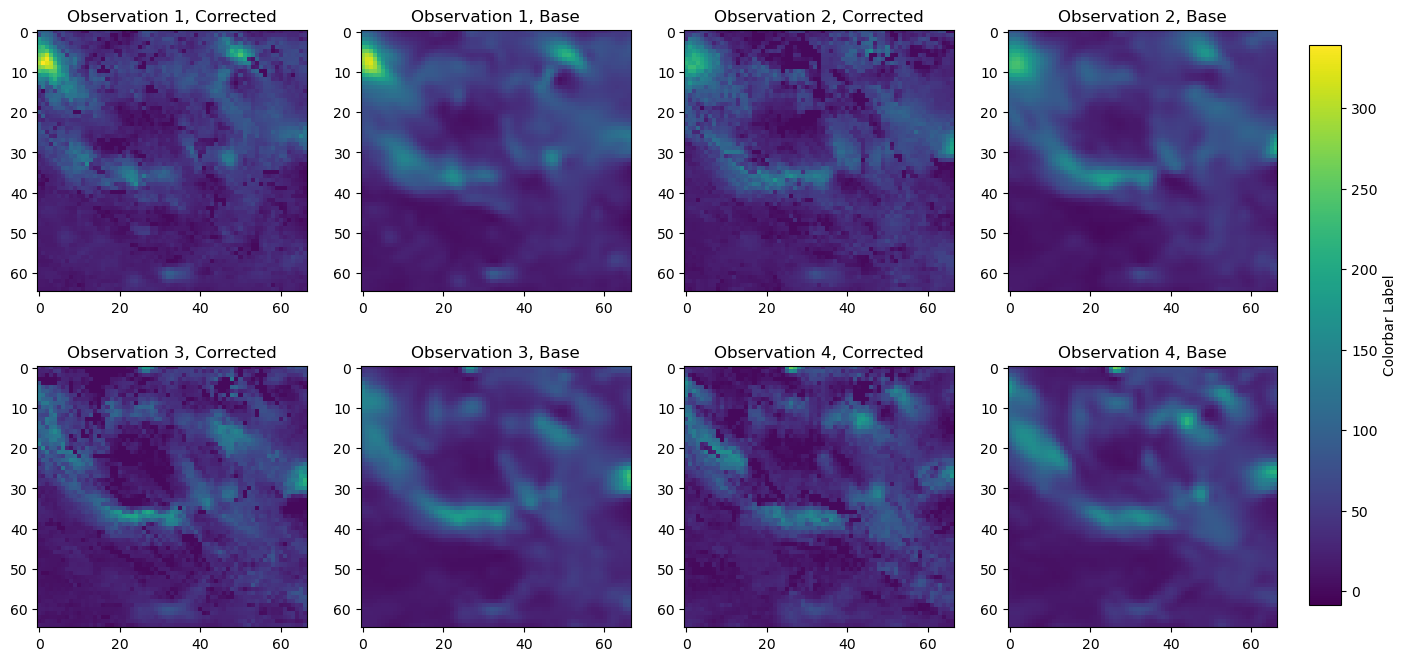

In [173]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
ax = axes.ravel()
start_index = 2355
length = 8
number_list = [start_index + i for i in range(length)]
vmax = max(final_tensor[number_list, 1, :, :].max(), final_tensor[number_list, 0, :, :].max())
vmin = min(final_tensor[number_list, 1, :, :].min(), final_tensor[number_list, 0, :, :].min())
count = 1

for i in range(0, 8, 2):
    im1 = ax[i].imshow(final_tensor[start_index + i, 1, :, :], vmax=vmax, vmin=vmin)
    ax[i].set_title(f'Observation {count}, Corrected')

    im2 = ax[i + 1].imshow(final_tensor[start_index + i, 0, :, :], vmax=vmax, vmin=vmin)
    ax[i + 1].set_title(f'Observation {count}, Base')

    count += 1

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = plt.colorbar(im1, cax=cbar_ax)
cbar.set_label('Colorbar Label')

plt.show()